# Introduction

Notre dataset comporte  46102 lignes correspondant chacune à une vidéo Youtube issue d'une parmi 58	 chaines de médias	 français. Nous avons 28 variables avec aucune valeur manquante.

# Fonctions

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.svm import LinearSVR
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
sns.set_style('darkgrid')
plt.rc('figure', figsize=[12, 9])
scaler = StandardScaler()

In [3]:
nbr_columns = ['nbrMotInsulte', 'nbrMot', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark']
comment_columns = ['message_count', 'thread_count', 'discussion_count']
auth_columns = ['distinct_authors_count', 'authors_3channels_count', 'liked_authors_count']
mean_columns = ['nbrMotMoyenne', 'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne',
                'nbrMotMAJMoyenne', 'nbrExclMarkMoyenne', 'nbrQuestMarkMoyenne']
num_columns = nbr_columns + comment_columns + auth_columns + mean_columns + ['subscriberCount', 'viewCount']
cat_columns = ['categorie_new', 'categ_inst']

In [4]:
# fonctions pour afficher et comprendre les données

def describe_cat_data(df):
    mv = 'some' if df.isnull().values.any() else 'no'
    msg = 'We have ' + str(len(num_columns)) + ' numerical features and ' + str(len(cat_columns)) + \
          ' categorical features for ' + str(len(df.index)) + ' samples.\nThere are ' + mv + ' missing values in this dataset.\n'
    for c in cat_columns:
        plot_scatter(df, c)
        plot_categorical(df, c)


def describe_num_data(df):
    for c in num_columns:
        if c != 'nbrMotInsulte':
            plot_scatter(df, c)
        plot_hist(df, c)


def plot_scatter(df, feature):
    plt.figure()
    plt.title('Plot of number of insulting words by ' + feature)
    plt.scatter(df[feature], df['nbrMotInsulte'])
    plt.show()


def plot_hist(df, feature):
    plt.figure()
    plt.title('Plot of histogram of ' + feature)
    df[feature].hist()
    plt.show()


def plot_categorical(df, feature):
    counts = df[feature].value_counts(normalize=True)
    plt.figure()
    plt.title('Plot of the percentage of samples per distinct value of ' + feature)
    plt.bar(counts.index, counts, align='center', alpha=0.5)
    plt.xticks(counts.index, counts.index)
    plt.show()
    
    
def find_outliers(df, df2):
    for c in num_columns:
        plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Boxplots of ' + c + ' for Youtube comments, with and without outliers')
        sns.boxplot(ax=ax1, data=df[c], fliersize=10)  # fliersize is the size used to indicate the outliers
        sns.boxplot(ax=ax2, data=df2[c], fliersize=10)
        plt.show()
        

def correlation_matrix(df, log=False):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Generate a custom diverging colormap
    plt.figure()
    title = 'Correlation matrix for Youtube comments'
    if log:
        title += ' with log numerical values'
    plt.title(title)
    sns.heatmap(corr, mask=mask)
    plt.show()

In [5]:
# Fonctions pour la création du dataset

# outputs the following list: [X_train, y_train, X_test, y_test]
def create_dataset(plot=False, log=False):
    df = load_dataset()
    if log:
        df = modify_num_data(df, plot)
    df = one_hot_encoding(df)
    df2 = df.sample(frac=0.8, random_state=42)  # must set a seed value in random_state option
    test = df.drop(df2.index, axis=0)
    train = remove_outliers(df)
    if plot:
        find_outliers(df, train)
        describe_num_data(train)
    X_train, y_train = data_and_label(train)
    X_train = normalize(X_train)
    X_test, y_test = data_and_label(test)
    X_test = normalize(X_test, False)
    print('dataset created')
    return [X_train, y_train, X_test, y_test]


def load_dataset():
    df = pd.read_csv('Dataset/challenge_youtube_toxic.csv', encoding ='unicode_escape', sep=';', decimal=',')
    # channel name does not seem relevant and will create a lot of dimensions with the one hot encoding
    df = df.drop(['channel_name', 'video_id', 'video_id_court', 'channel_id', 'Unnamed: 27'], axis=1)
    return df


def modify_num_data(df, plot):
    #cols = nbr_columns + comment_columns + auth_columns 
    #df[cols] = df[cols].apply(lambda x: np.log(x+1))
    df[num_columns] = df[num_columns].apply(lambda x: np.log(x+1))
    return df


def remove_outliers(df, log=False):

    for c in nbr_columns:
        if c != 'nbrMot':
            df = df[df[c] <= 2000]
            df = df[df[c] <= 30 * df['message_count']]
        else:
            df = df[df[c] <= 400000]
            df = df[df[c] <= 1000*df['message_count']]

    '''# for the number of words or messages, we just leave out the very isolated ones
    df = df[df['nbrMot'] <= 400000]
    df = df[df['message_count'] <= 8000]
    df = df[df['distinct_authors_count'] <= 7500]
    df = df[df['subscriberCount'] <= 400000]'''
    return df


def one_hot_encoding(df):
    one_hot = pd.get_dummies(df[cat_columns])
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(cat_columns, axis=1)
    return df


def data_and_label(df):
    y = df['nbrMotInsulte']
    y = y.to_numpy()
    X = df.drop(['nbrMotInsulte'], axis=1)
    return [X, y]


def normalize(data, train=True):
    if train:
        scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), columns=data.columns)

In [6]:
# fonctions pour la régression

def parameter_tuning(reg, grid, how='grid_search', cv=5, verbose=3, n_jobs=3):
    if how == 'grid_search':
        search = GridSearchCV(reg, grid, scoring='neg_mean_squared_error', cv=cv, verbose=verbose, n_jobs=n_jobs)
    else:
        search = RandomizedSearchCV(reg, grid, n_iter=10, scoring='neg_mean_squared_error',
                                    cv=cv, verbose=verbose, random_state=42, n_jobs=n_jobs)
    search.fit(X_train, Y_train)
    print('cross validation score of ' + str(search.best_estimator_) + ': ' + str(search.best_score_))
    scores_on_train[str(search.best_estimator_)] = search.best_score_
    return search.best_estimator_


def show_one_parameter(algo, param, values, kwargs=None, cv=5, n_jobs=3):
    if not kwargs:
        kwargs = {}
    scores = []
    reg = None
    for value in values:
        kwargs[param] = value
        reg = algo(**kwargs)
        scores.append(cross_val_score(reg, X_train, Y_train, scoring='neg_mean_squared_error',
                                      cv=cv, n_jobs=n_jobs, verbose=3).mean())
    plt.figure()
    plt.title('Negative mean squared error of ' + str(reg) + ' with tuning of ' + str(param))
    plt.plot(values, scores)
    plt.xlabel(param)
    plt.ylabel('Negative MSE')
    plt.show()


def plot_results(reg, log=False):
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_pred, Y_test)
    r2 = r2_score(y_pred, Y_test)
    print('scores on test set')
    print('MSE: ', mse)
    print('r2: ', r2)
    ratio = ratio_of_right_predictions(y_pred, Y_test, log)
    print()
    sort_ind = np.argsort(Y_test)
    y1, y2 = [], []
    for ind in sort_ind:
        y1.append(y_pred[ind])
        y2.append(Y_test[ind])
    x = range(len(y1))
    plt.figure()
    plt.title('Confrontation with ground truth ' + str(reg))
    plt.plot(x, y1, color='r', label='prediction')
    plt.plot(x, y2, color='b', label='ground truth')
    plt.xlabel('ordered samples')
    plt.ylabel('number of insult words')
    plt.legend()
    plt.show()
    mse_on_test[str(reg)] = mse
    r2_on_test[str(reg)] = r2
    ratio_on_test[str(reg)] = ratio
    

def ratio_of_right_predictions(y_pred, Y_test, log):
    count = 0
    for i in range(len(Y_test)):
        if log:
            if abs(np.exp(Y_test[i]) - np.exp(y_pred[i])) < 0.5:
                count += 1
        else:
            if abs(Y_test[i] - y_pred[i]) < 0.5:
                count += 1
    ratio = count/len(Y_test)
    print('Ratio of right predictions: ', ratio)
    return ratio


def compare_scores():
    plt.figure()
    plt.title('Mean squared error obtained by cross validation on train set for every algorithms')
    plt.bar(*zip(*scores_on_train.items()))
    plt.show()

    plt.figure()
    plt.title('Mean squared error on test set for every algorithms')
    plt.bar(*zip(*mse_on_test.items()))
    plt.show()

    plt.figure()
    plt.title('Coefficient of determination on test set for every algorithms')
    plt.bar(*zip(*r2_on_test.items()))
    plt.show()
    
    if len(ratio_on_test) > 0:
        plt.figure()
        plt.title('Ratio of right predictions on test set for every algorithms')
        plt.bar(*zip(*ratio_on_test.items()))
        plt.show()

# Compréhension data

Chargement du dataset en enlevant les colonnes inutiles (les ids et le nom des chaînes). On peut remarquer qu'il y a 2 colonnes de type catégorielles et le reste qui est numérique, composé de 6 features donnant des nombres de mots ou des nombres de marqueurs, et de 6 features moyennes correspondantes, les divisant respectivement par le nombre de commentaires. Nous pouvons nous demander si ces features moyennes (plus interprétables car ayant une distribution plus uniforme) ne suffisent pas à notre dataset, ceci dit il faut garder de toute façon notre nbrMotInsulte puisqu'il s'agit de notre valeur cible. 

Ensuite, on a 3 variables numériques relatives aux auteurs et le nombre de vues et d'abonnés. Le nombre de messages est donné et fait la somme du nombre de top commentaires et de sous commentaires, on peut aussi se demander si l'on ne peut pas enlever l'une de ces trois variables vu qu'ils sont en combinaison linéaire.

In [7]:
df = load_dataset()
df.head()

nbrMot  nbrMotInsulte  nbrMotAllong  nbrMotMAJ  nbrExclMark  nbrQuestMark  \
0    3813             18             4        145           79            60   
1      28              2             0          1            0             0   
2    3804             68             9         56           75            54   
3       4              0             1          2            0             0   
4     737              3             1         18            5             6   

   nbrMotMoyenne  nbrMotInsulteMoyenne  nbrMotAllongMoyenne  nbrMotMAJMoyenne  \
0      30.261900              0.142857             0.031746          1.150794   
1       9.333333              0.666667             0.000000          0.333333   
2      27.565220              0.492754             0.065217          0.405797   
3       2.000000              0.000000             0.500000          1.000000   
4      32.043478              0.130435             0.043478          0.782609   

   ...  comment_count  message_count  discussion_count  \
0  ...             81            126                28   
1  ...              0              3                 0   
2  ...             86            138                22   
3  ...              0              2                 0   
4  ...              6             23                 4   

   distinct_authors_count  authors_3channels_count  liked_authors_count  \
0                      58                       47                   23   
1                       3                        1                    0   
2                      83                       49                   36   
3                       2                        0                    0   
4                      18                        7                    7   

   subscriberCount  viewCount  categorie_new        categ_inst  
0           339922  225393312           Core      Pure Players  
1           189971  132125693           Core                TV  
2           339922  225393312           Core      Pure Players  
3             2862    2481100          Niche  Presse_regionale  
4            30010    6710737           Core  Presse nationale  

[5 rows x 23 columns]

On constate que pour toutes les variables numériques exceptées subscriberCount et viewCount on a un très grand écart type par rapport à la distribution des valeurs puisque étant supérieur à la différence entre la valeur minimum et le troisième quartile. Nous avons donc pour idée de prendre le logarithme des valeurs numériques exceptées ces deux features.

In [8]:
df.describe()

nbrMot  nbrMotInsulte  nbrMotAllong     nbrMotMAJ   nbrExclMark  \
count   46102.000000   46102.000000  46102.000000  46102.000000  46102.000000   
mean     1435.853564       9.418225      3.974665     21.922823     21.823066   
std      7670.789422      61.616732     21.367879    130.038591    120.607203   
min         0.000000       0.000000      0.000000      0.000000      0.000000   
25%        18.000000       0.000000      0.000000      0.000000      0.000000   
50%        72.000000       0.000000      0.000000      0.000000      1.000000   
75%       398.000000       3.000000      1.000000      6.000000      9.000000   
max    662808.000000    7227.000000   1416.000000  14270.000000  11093.000000   

       nbrQuestMark  nbrMotMoyenne  nbrMotInsulteMoyenne  nbrMotAllongMoyenne  \
count  46102.000000   46102.000000          46102.000000         46102.000000   
mean      13.591276      25.264768              0.189175             0.080849   
std       68.803038      31.979351              0.444356             0.305948   
min        0.000000       0.000000              0.000000             0.000000   
25%        0.000000       9.769231              0.000000             0.000000   
50%        1.000000      18.630032              0.000000             0.000000   
75%        4.000000      31.000000              0.222222             0.068821   
max     5520.000000    1349.500000             14.000000            28.000000   

       nbrMotMAJMoyenne  ...  nbrQuestMarkMoyenne  thread_count  \
count      46102.000000  ...         46102.000000  46102.000000   
mean           0.583485  ...             0.276134     22.219145   
std            3.114312  ...             0.950349    117.441322   
min            0.000000  ...             0.000000      1.000000   
25%            0.000000  ...             0.000000      1.000000   
50%            0.000000  ...             0.040161      3.000000   
75%            0.400000  ...             0.333333      9.000000   
max          162.000000  ...           120.750000   8734.000000   

       comment_count  message_count  discussion_count  distinct_authors_count  \
count   46102.000000   46102.000000      46102.000000            46102.000000   
mean       25.700816      47.919960          5.040085               28.726021   
std       130.742237     234.791106         19.578795              140.334032   
min         0.000000       1.000000          0.000000                1.000000   
25%         0.000000       1.000000          0.000000                1.000000   
50%         0.000000       4.000000          0.000000                3.000000   
75%         5.000000      16.000000          2.000000               11.000000   
max     11195.000000   19336.000000       1235.000000             9837.000000   

       authors_3channels_count  liked_authors_count  subscriberCount  \
count             46102.000000         46102.000000     46102.000000   
mean                 14.502646            10.974036    172108.752744   
std                  56.251117            50.607716    119508.318824   
min                   0.000000             0.000000         0.000000   
25%                   1.000000             0.000000     87793.000000   
50%                   2.000000             1.000000    180173.000000   
75%                   7.000000             4.000000    217835.000000   
max                3762.000000          3732.000000    568615.000000   

          viewCount  
count  4.610200e+04  
mean   9.255061e+07  
std    6.778302e+07  
min    3.109100e+04  
25%    4.635634e+07  
50%    6.388093e+07  
75%    1.321257e+08  
max    2.414350e+08  

[8 rows x 21 columns]

Les variables catégorielles sont relativement déséquilibrées avec notamment les news dont la chaîne est de type coeur qui représentent plus de 80% du jeu de données. Pour les catégories de news,  les alternatives représentent moins de 2% des données contre 32% pour la presse nationale par exemple. 

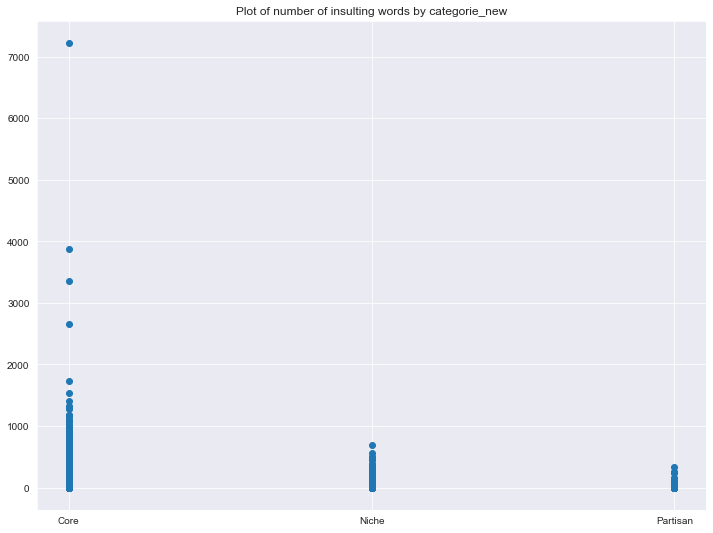

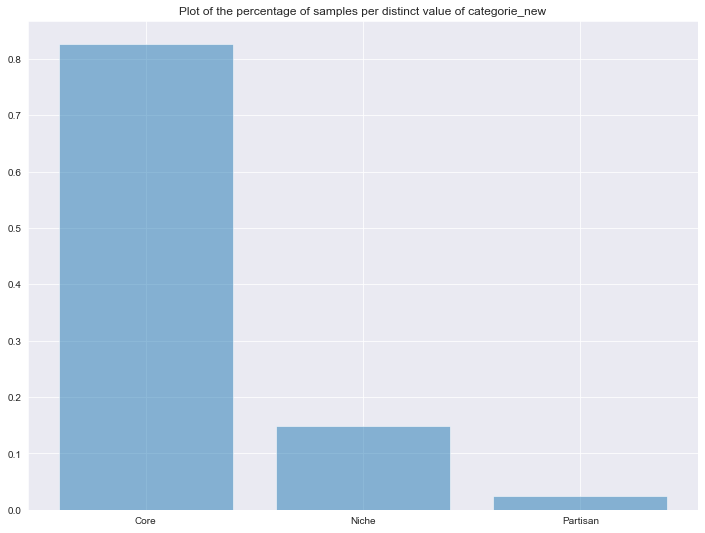

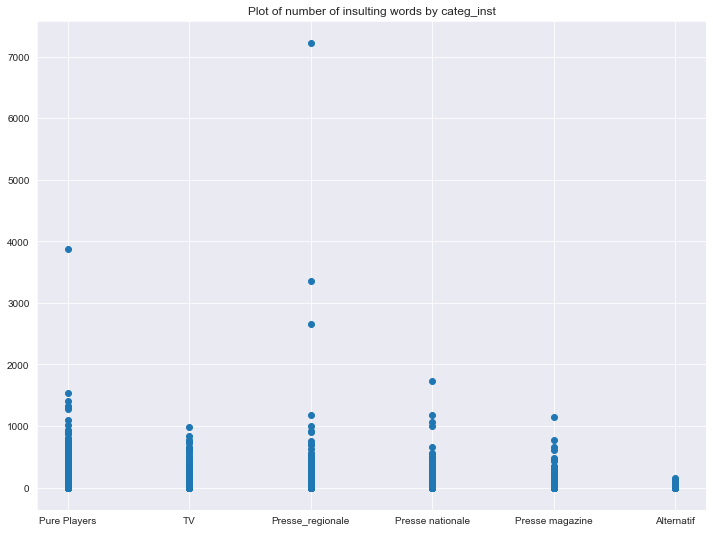

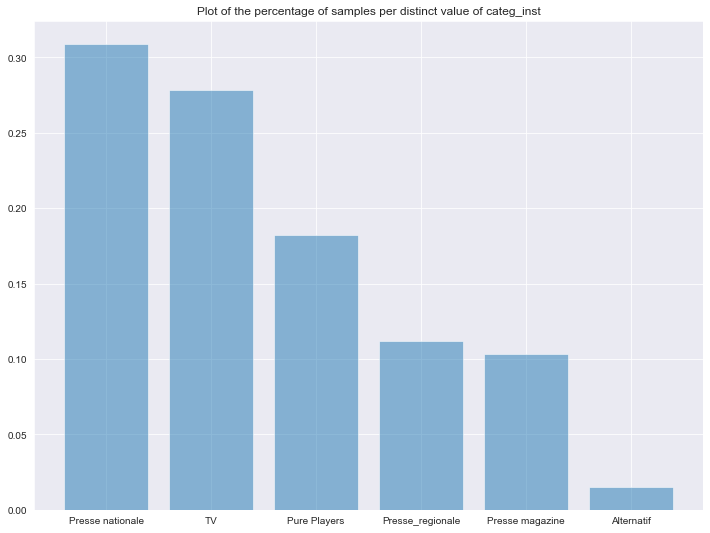

In [9]:
describe_cat_data(df)

La matrice de corrélation nous montre une forte corrélation entre les nombres de mots et de marqueurs entre eux, et les nombres de commentaires et d'auteurs de commentaires. Nous pouvons nous douter que plus le nombre de commentaires est grand, plus tous ces nombres sont grands. Quand on regarde les moyennes, on voit qu'elles sont moins corrélées entre elles que les nombres ne l'étaient.

Pour le décompte des abonnés et des vues, la corrélation est assez faible avec les autres features, sauf les données catégorielles.

Ensuite, pour les variables catégorielles, on a une corrélation très faible pour l'ensemble des features à part pour les news de Niche et les Pure players, qui ont quand même une corrélation assez faible avec les autres features que les moyennes. Les catégories Partisan et Alternatif sont très fortement corrélées, de même que Core et Presse nationale sont corrélés négativement par exemple.

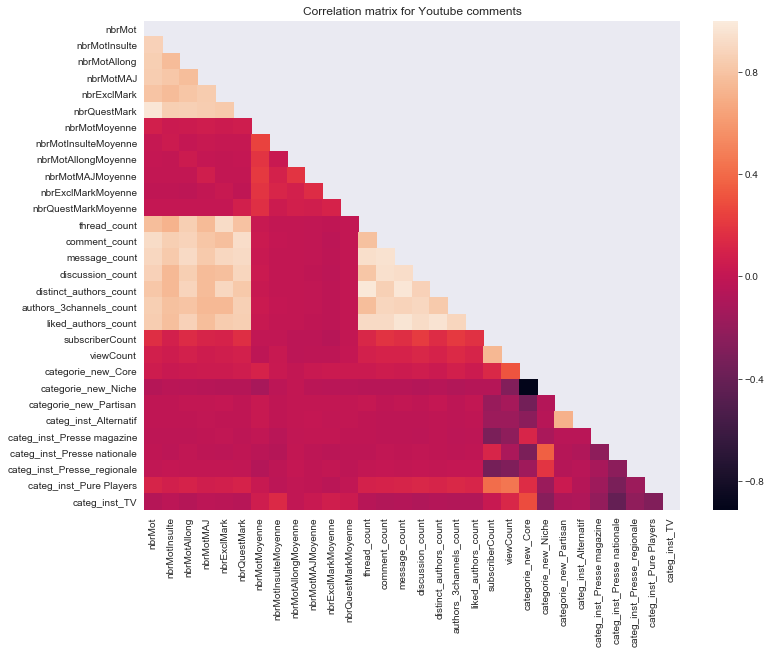

In [10]:
df_corr = one_hot_encoding(df)
correlation_matrix(df_corr)

# Regression on dataset with outliers limit

Avec les boxplots, nous avons confirmation qu'en laissant les features numériques dont nous avons parlé telles quelles, le nombre d'outliers est extrêmement important. De plus, les moyennes sont totalement décorrélées de nbrMotInsulte.

Pour subscriber count, on peut voir qu'il y a deux groupes de données. 

Dans ce dataset, nous enlevons les outliers les plus évidents puis nous effectuons la normalisation standard. Cela nous servira pour vérifier que changer les données numériques en utilisant le log apporte une vraie plus-value.

<Figure size 864x648 with 0 Axes>

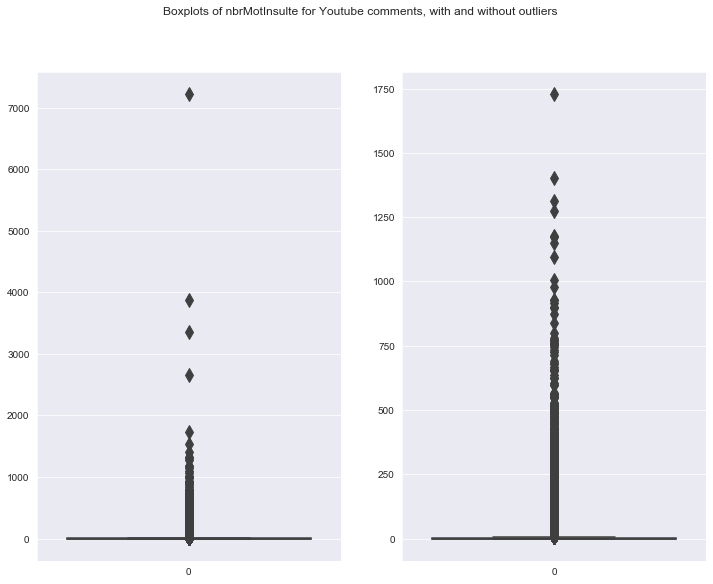

<Figure size 864x648 with 0 Axes>

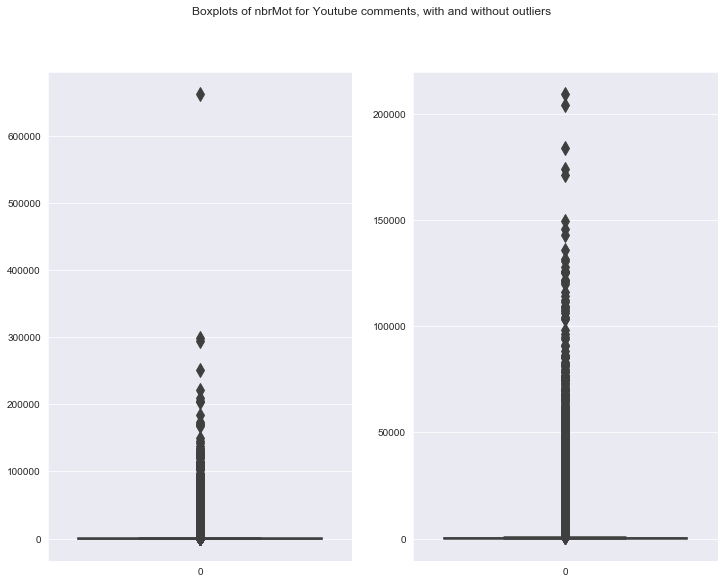

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

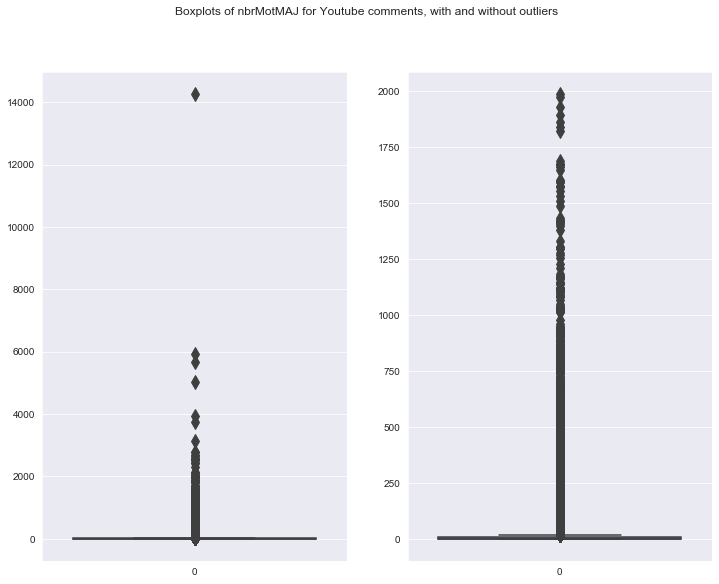

<Figure size 864x648 with 0 Axes>

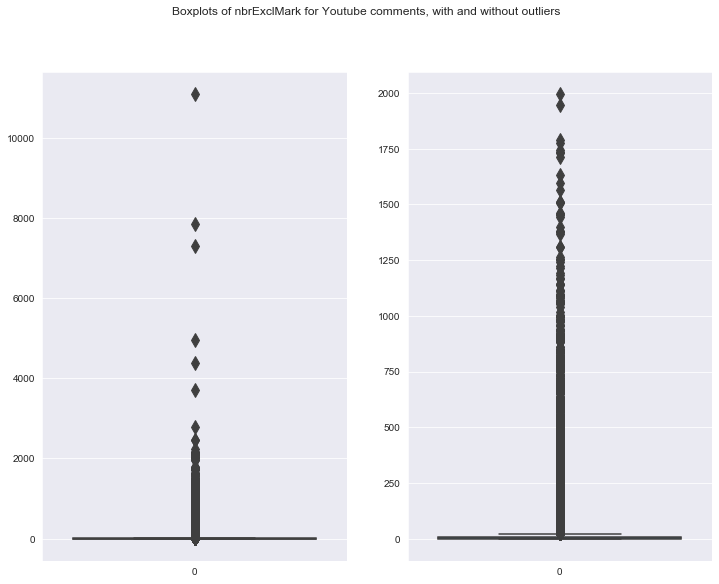

<Figure size 864x648 with 0 Axes>

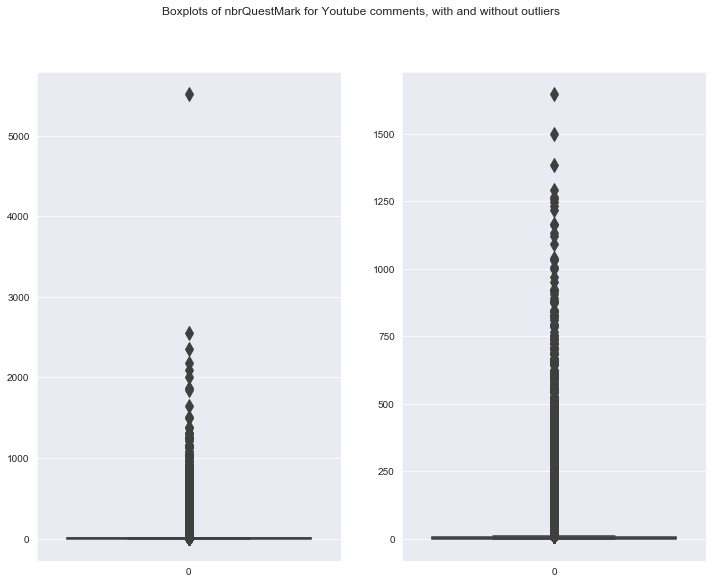

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

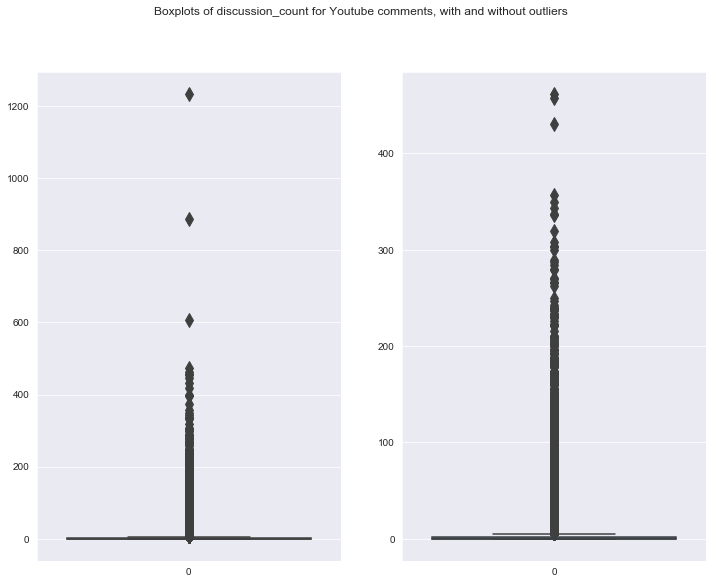

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

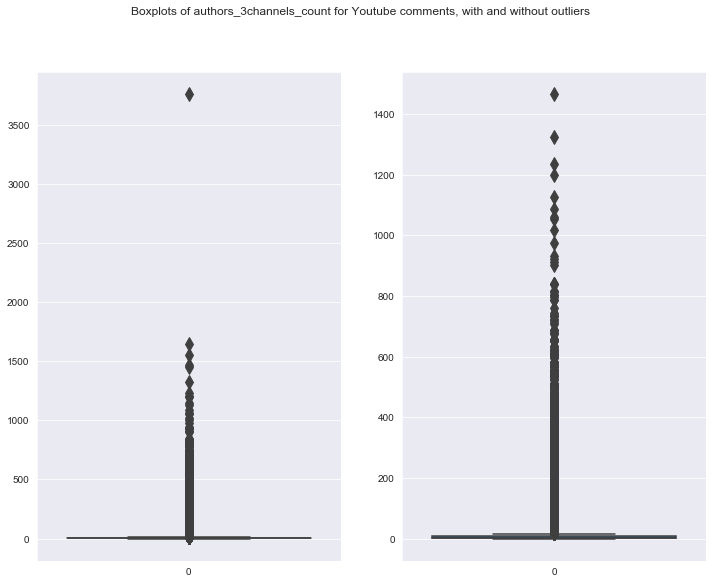

<Figure size 864x648 with 0 Axes>

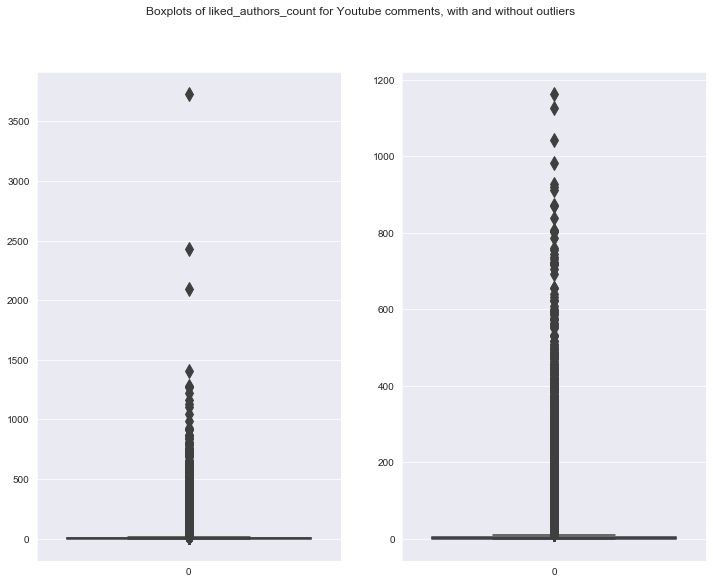

<Figure size 864x648 with 0 Axes>

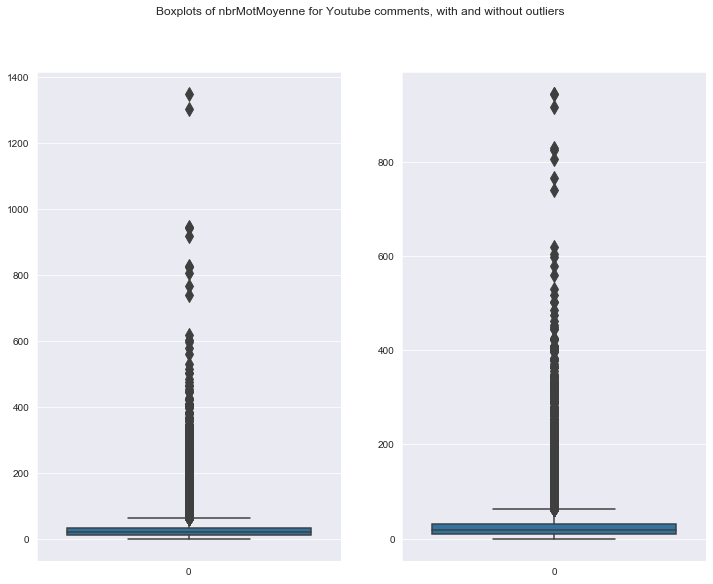

<Figure size 864x648 with 0 Axes>

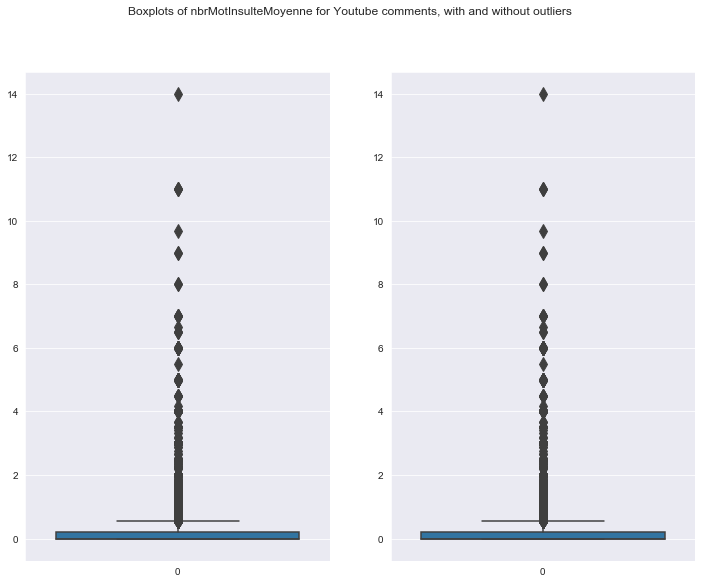

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

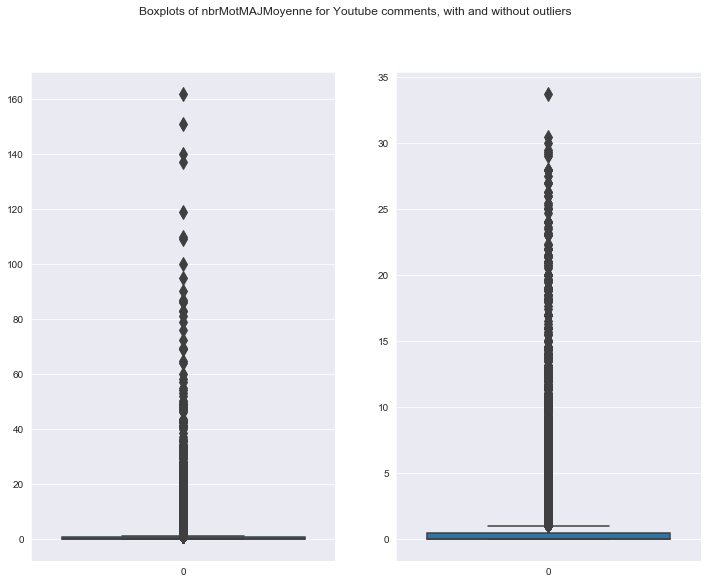

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

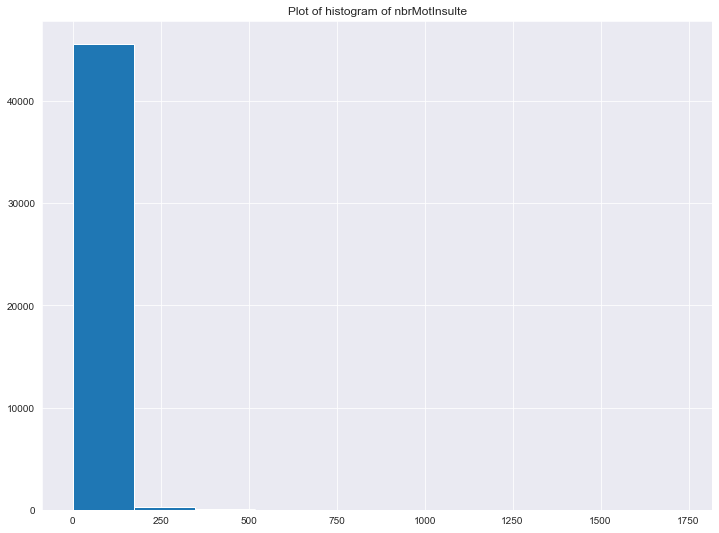

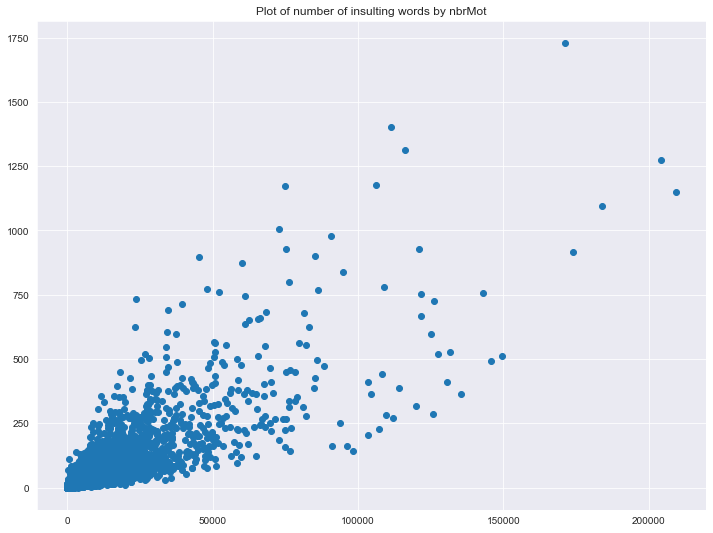

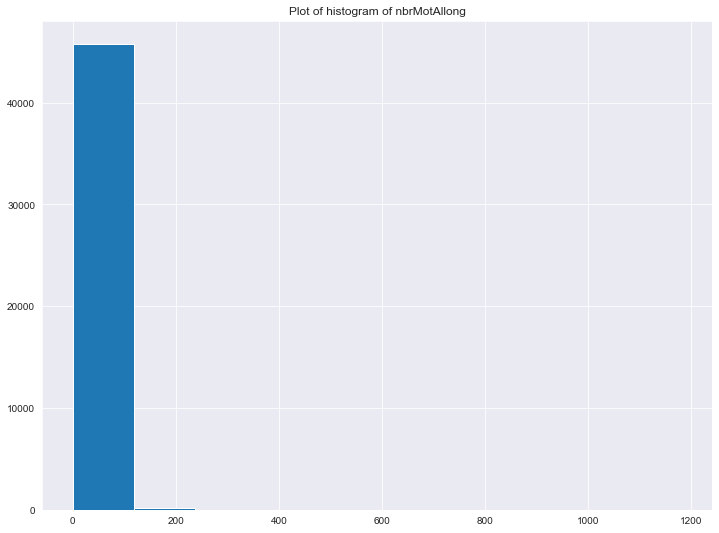

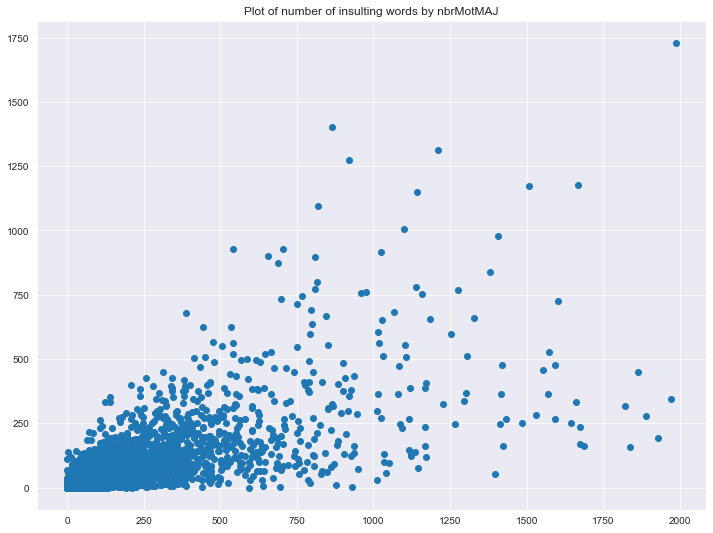

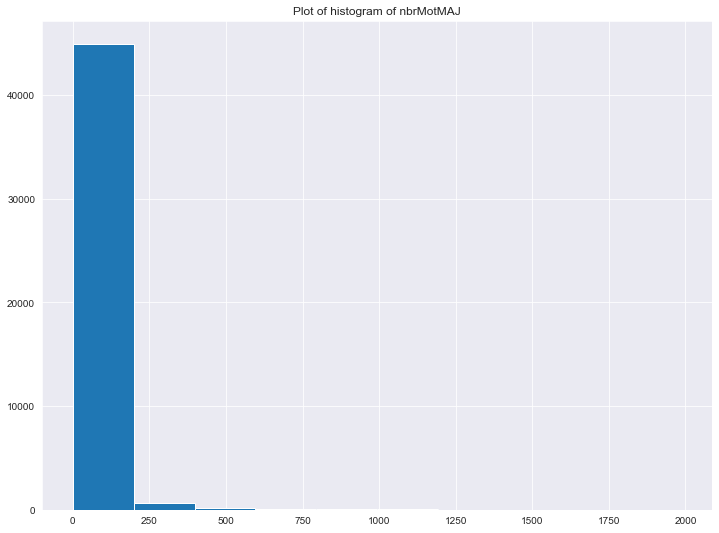

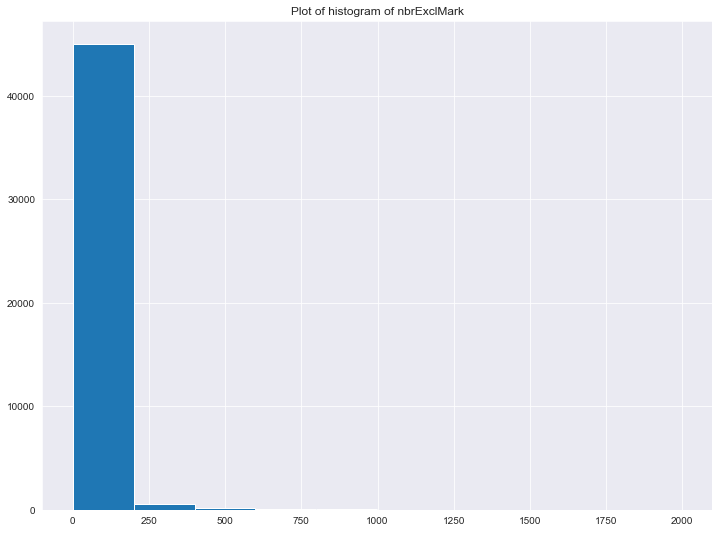

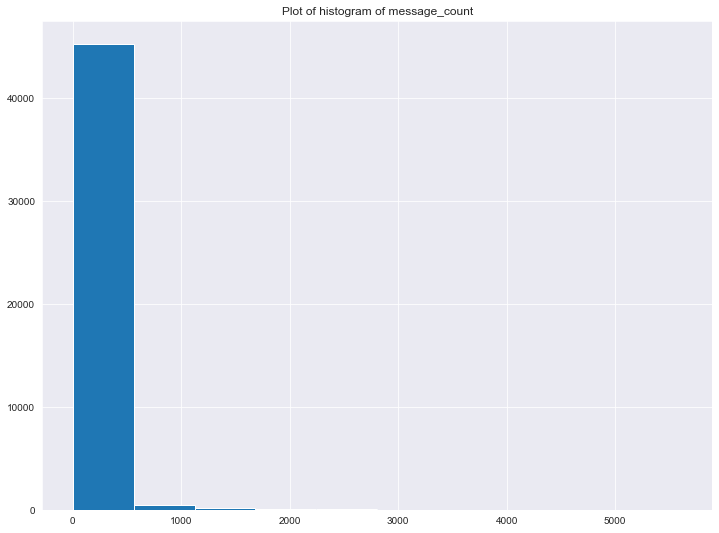

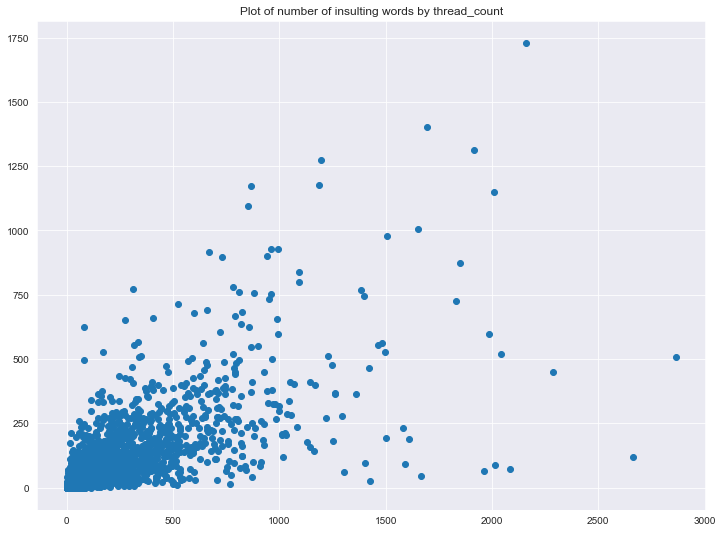

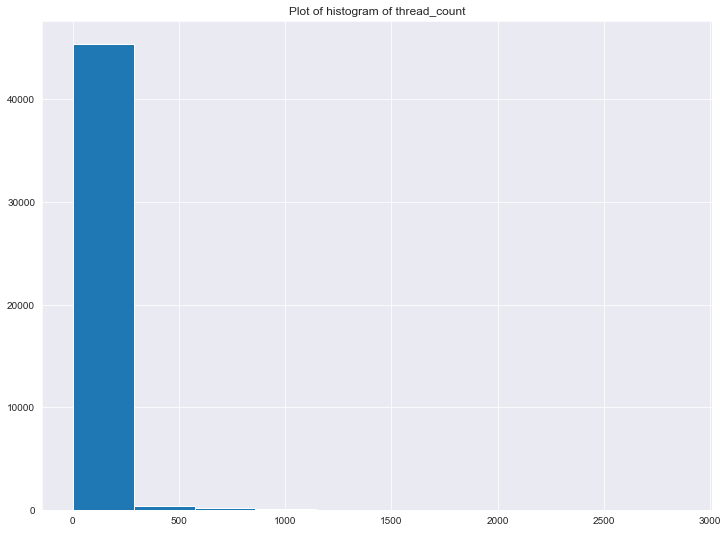

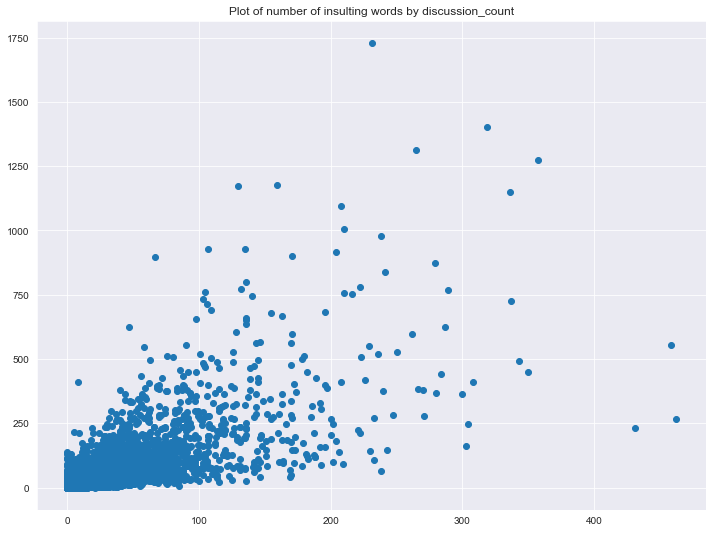

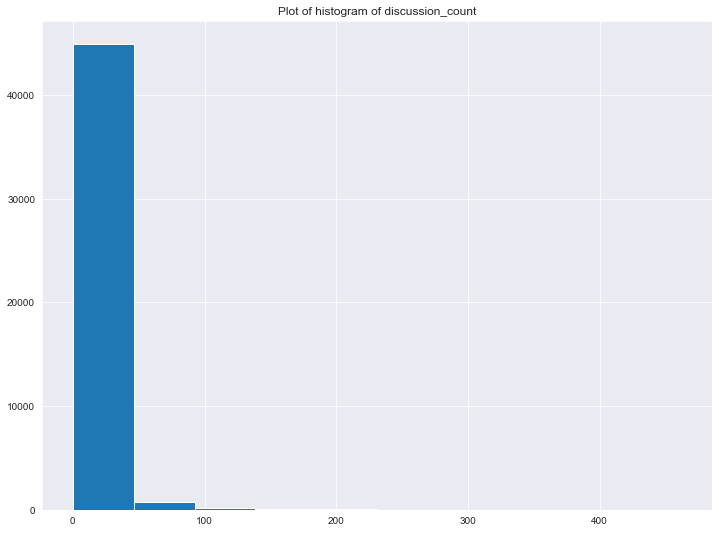

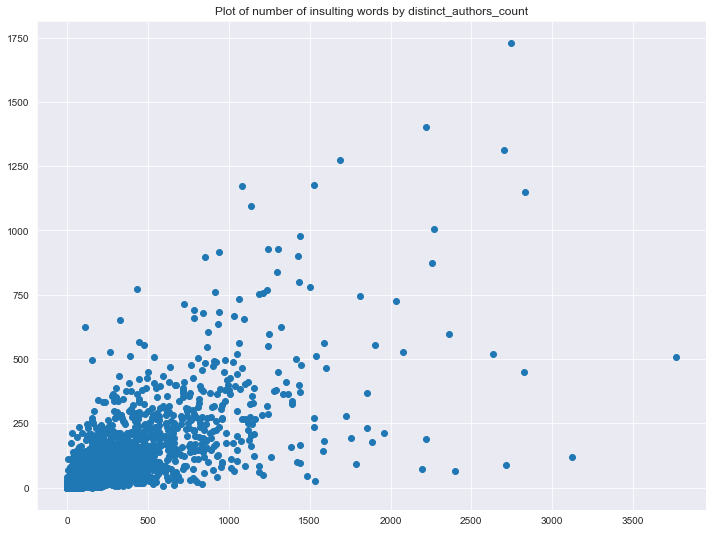

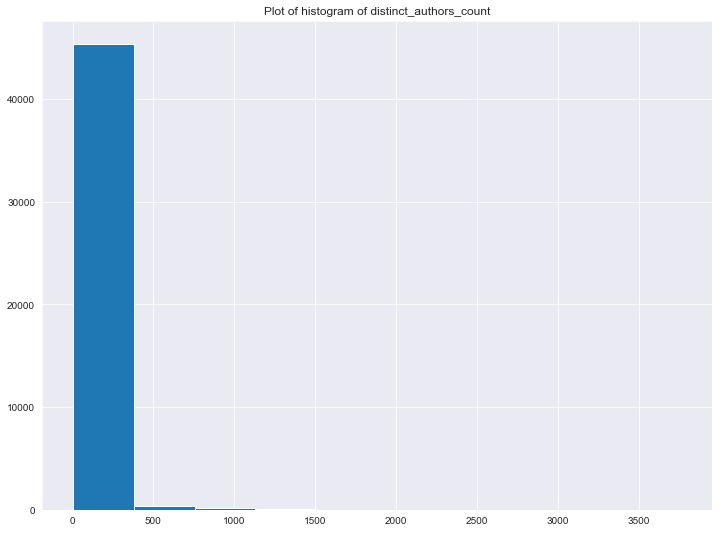

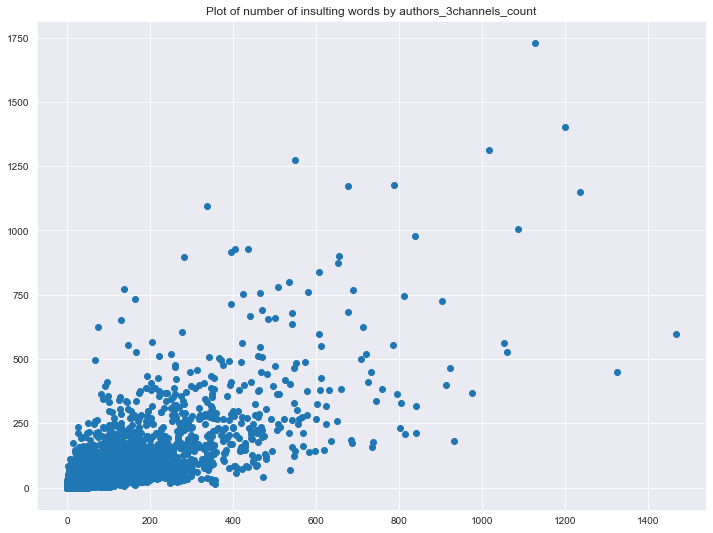

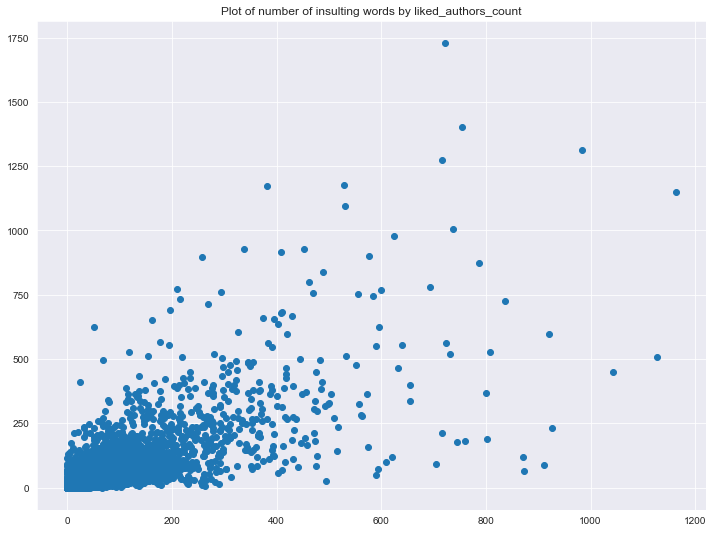

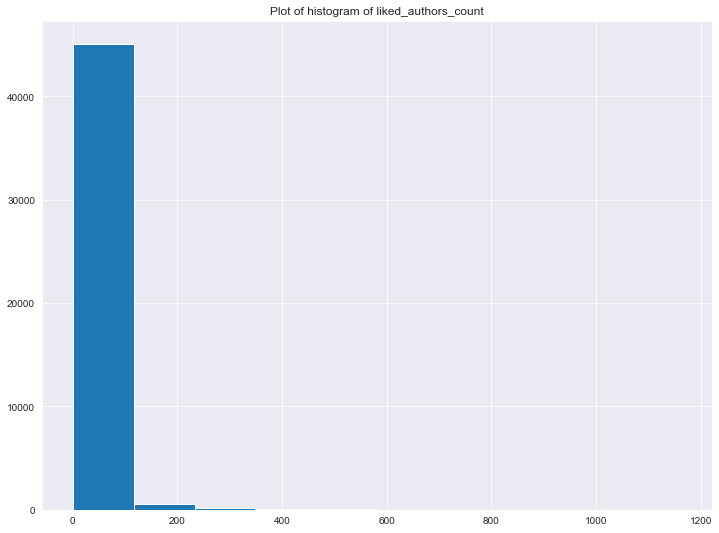

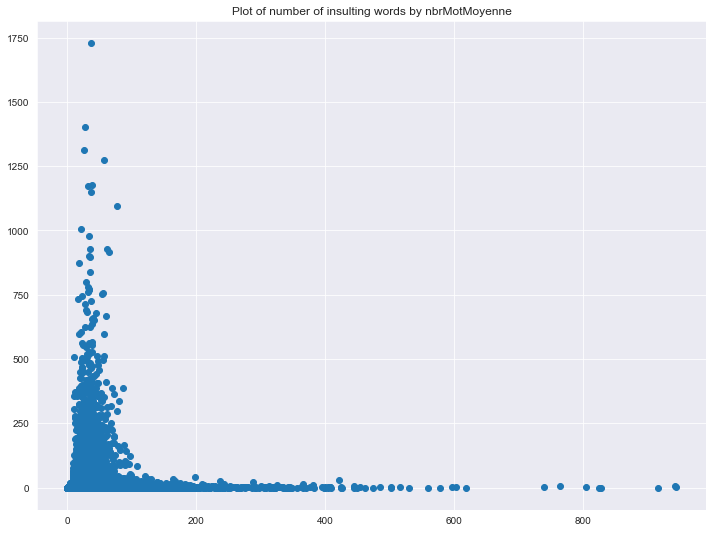

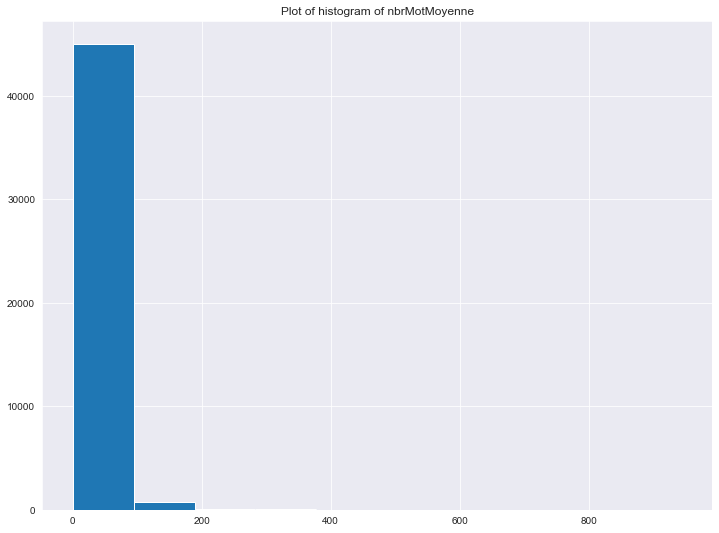

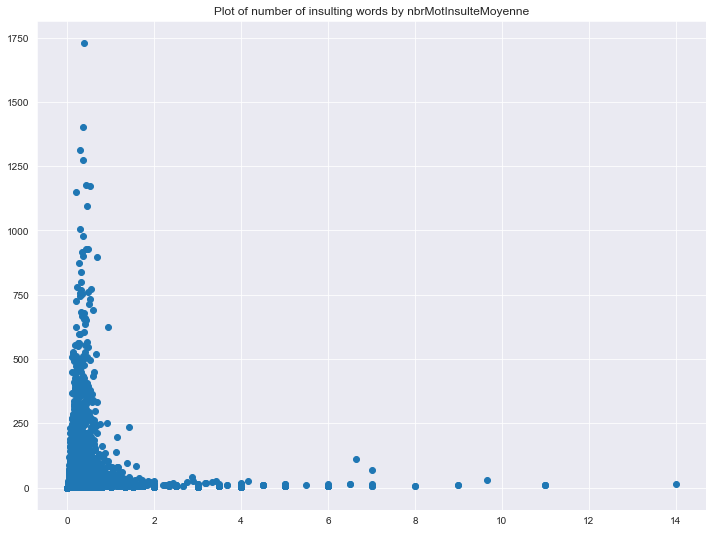

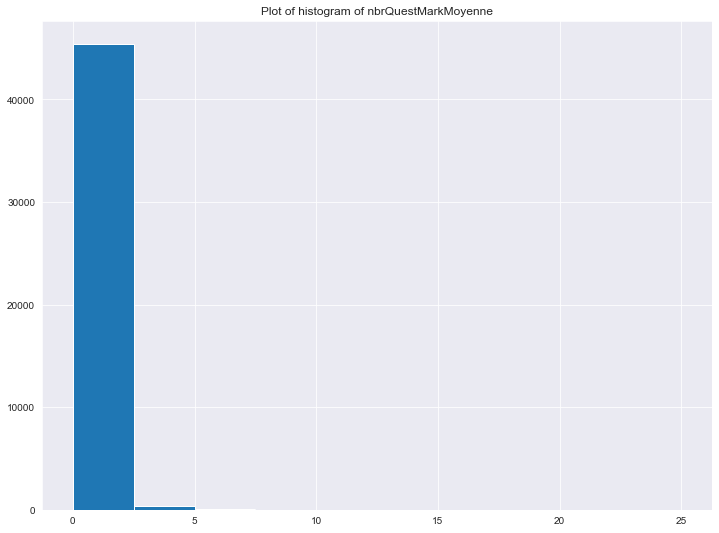

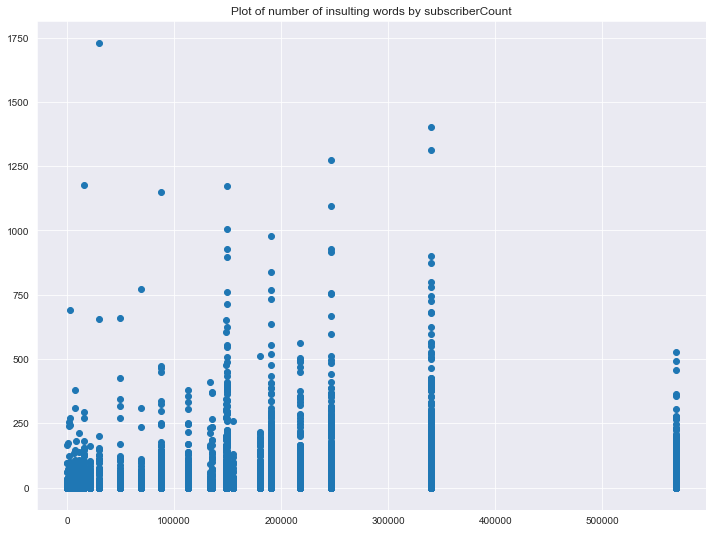

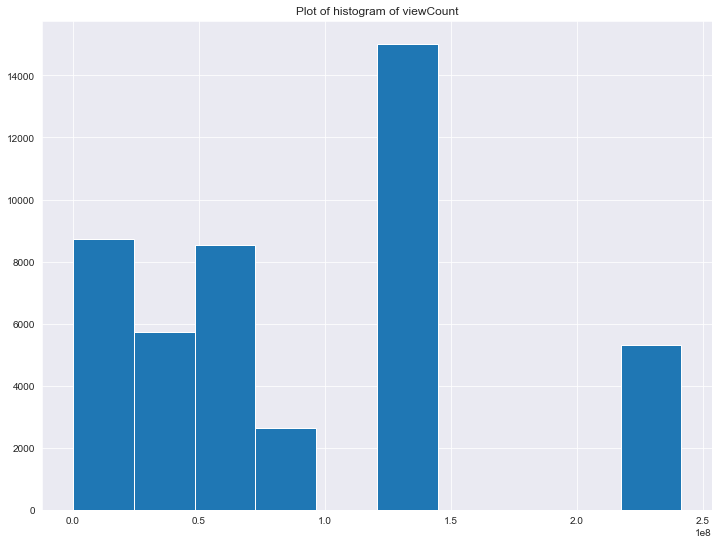

dataset created


In [11]:
X_train, Y_train, X_test, Y_test = create_dataset(plot=True, log=False)

In [12]:
scores_on_train = {}
mse_on_test = {}
r2_on_test = {}
ratio_on_test = {}

### KNN

Nous appliquons le KNN sur notre dataset en faisant un grid search sur le nombre de voisins, on obtient un MSE de 382 qui semble correct avec une moyenne d'environ 10 pour notre cible et 46000 samples.

In [13]:
algo = neighbors.KNeighborsRegressor
reg = algo()
reg = parameter_tuning(reg, {'n_neighbors': [2, 3, 4, 5]}, cv=3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  1.5min finished


cross validation score of KNeighborsRegressor(n_neighbors=4): -381.7291291676904


Nous affichons la courbe par rapport à ce paramètre, et nous voyons qu'un nombre plutôt élevé (environ 6) de voisins performe mieux.

In [14]:
show_one_parameter(algo, 'n_neighbors', list(range(2, 8)), cv=3)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   19.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   24.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   24.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.0s finished


Lorsque l'on regarde les scores sur les données de test, on voit qu'il y a un clair sur-entraînement et donc un nombre plus faible de voisins serait préférable. Le r2 est à 0.6 ce qui est assez mauvais au vu de la distribution avec des données qui sont quasiment toutes distribuées dans des valeurs entre 0 et 10, et quelques outliers avec des valeurs supérieures à la centaine que nous avons gardés.

Le nombre de bonnes prédictions (lorsqu'on regarde si on a prédit le bon entier) est relativement faible.

scores on test set
MSE:  774.3903063991323
r2:  0.6021729085660548
Ratio of right predictions:  0.6603036876355748



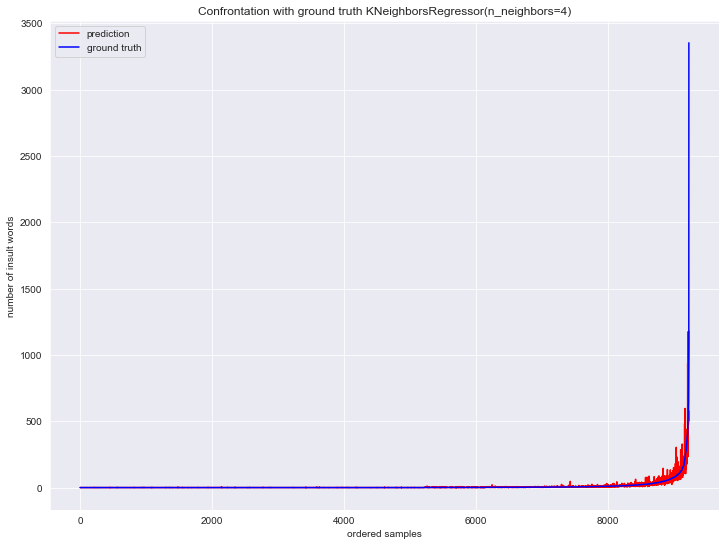

In [15]:
plot_results(reg)

### Decision tree

On effectue la même chose pour l'arbre de décision, ici on optimise par rapport au max_depth qui permet un pre-pruning.

In [16]:
algo = tree.DecisionTreeRegressor
reg = algo()
reg = parameter_tuning(reg, {'max_depth': [10, 15, 20, 25, 30, 40, 50, 70, 100]}, cv=3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:    6.0s finished


cross validation score of DecisionTreeRegressor(max_depth=15): -111.14662395918458


Le changement de valeur ne change pas grand chose, un max_depth plutôt faible est donc préférable.

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   

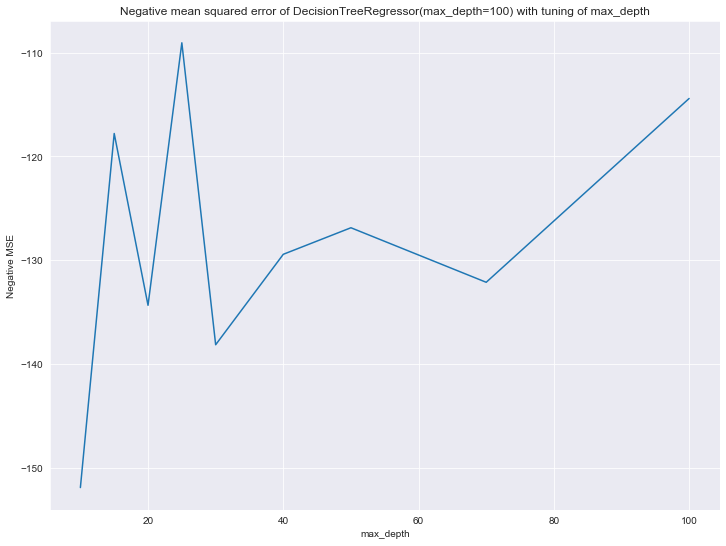

In [17]:
show_one_parameter(algo, 'max_depth', [10, 15, 20, 25, 30, 40, 50, 70, 100], cv=3)

L'optimisation du post-pruning semble plus impactant et diminuer significativement le MSE, on garde donc le paramètre par défaut.

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   

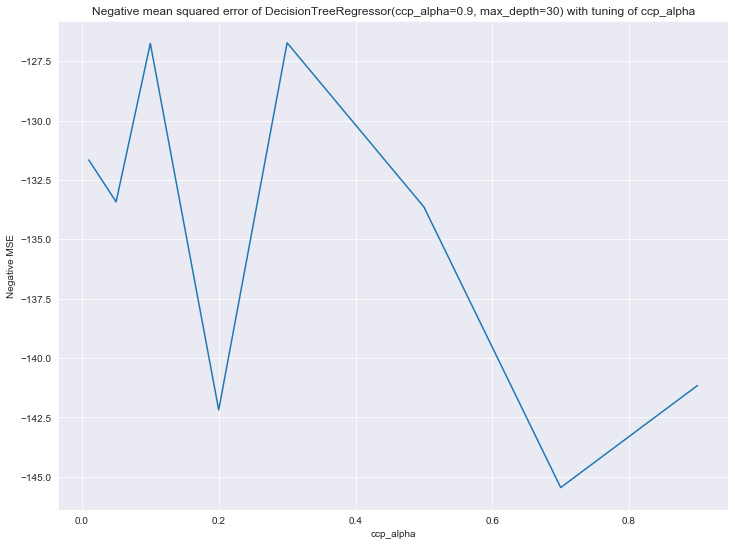

In [18]:
# ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning
show_one_parameter(algo, 'ccp_alpha', [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9], cv=3, kwargs={'max_depth': 30})

Les résultats sont meilleurs (avec notamment un ratio très haut de bonnes prédictions, on a donc surtout mal prédit des valeurs élevées), comme on peut d'ailleurs le voir sur le graphique qui confronte les véritables valeurs et les valeurs prédites.

In [19]:
plot_results(reg)

scores on test set
MSE:  338.3901420442297
r2:  0.8398809403483873
Ratio of right predictions:  0.9796095444685466



### Conclusion for regression with outliers limit

Nous voyons que ce dataset est mal adapté à la tache de régression, les outliers de la cible ayant une influence bien trop importante. Le decision performe le mieux sur le test set, mais nous voyons surtout la nécessité de changer les variables d'entrées en prenant le log (le plot de ground_truth a une forme caractéristique du log assez évidente).

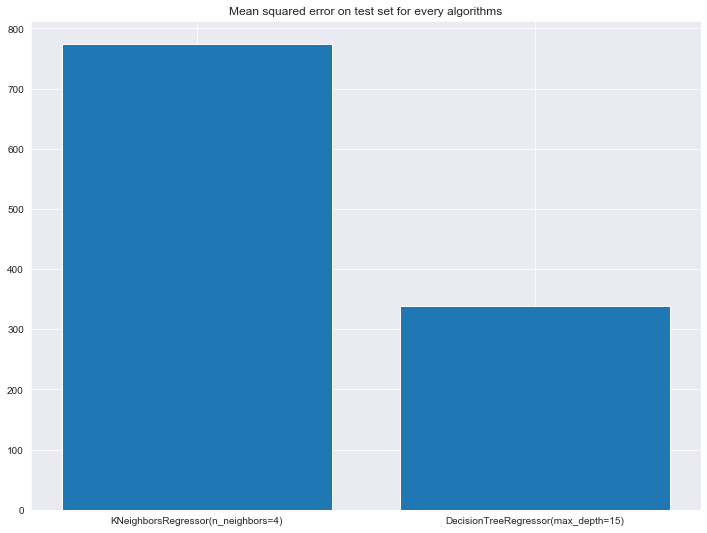

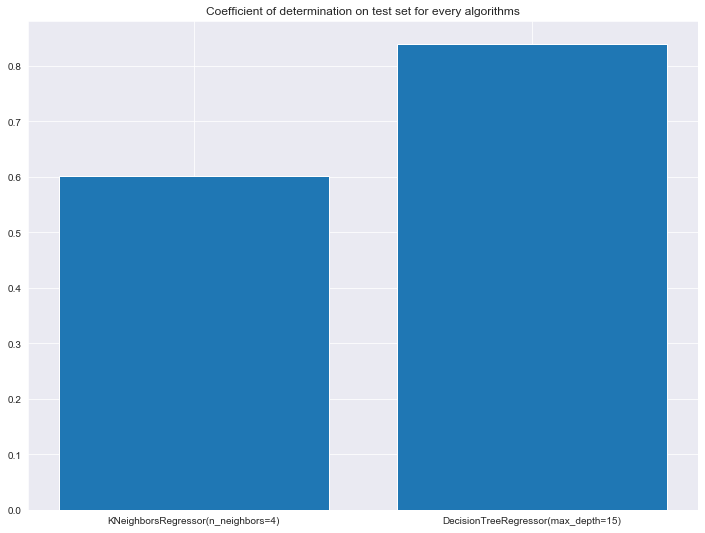

In [20]:
compare_scores()

# Regression on transformed dataset (with logs)

On a toujours un certain nombre d'outliers mais ici la distribution est bien plus uniforme en prenant le log de ces features.

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

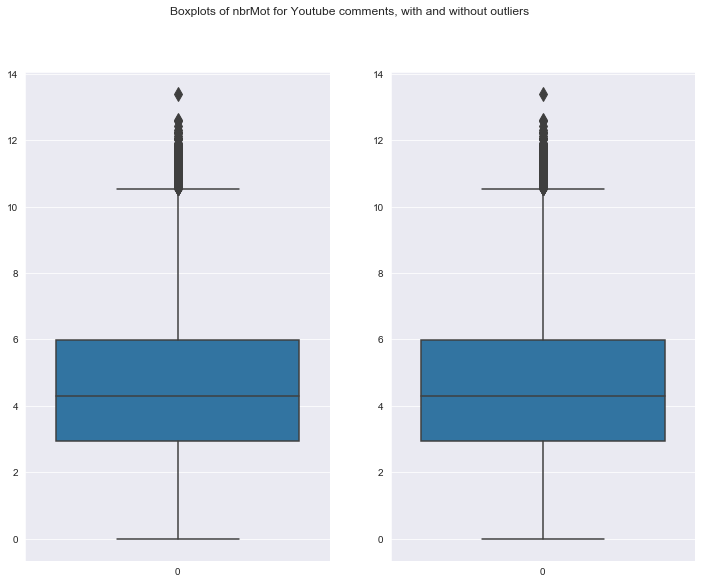

<Figure size 864x648 with 0 Axes>

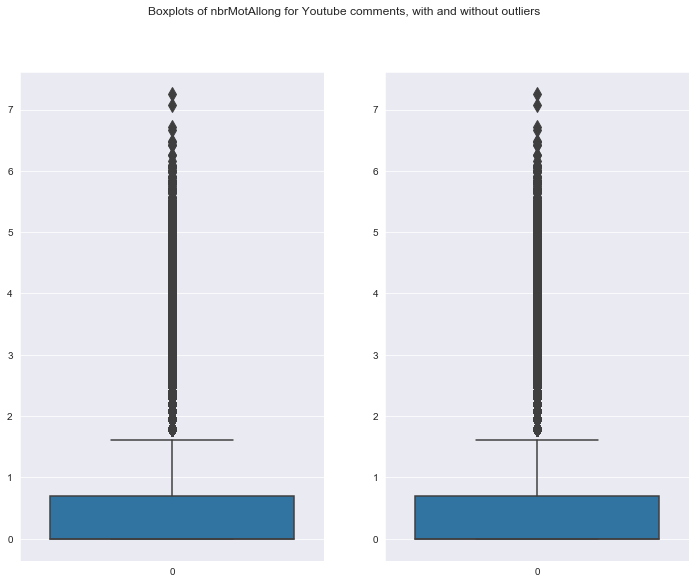

<Figure size 864x648 with 0 Axes>

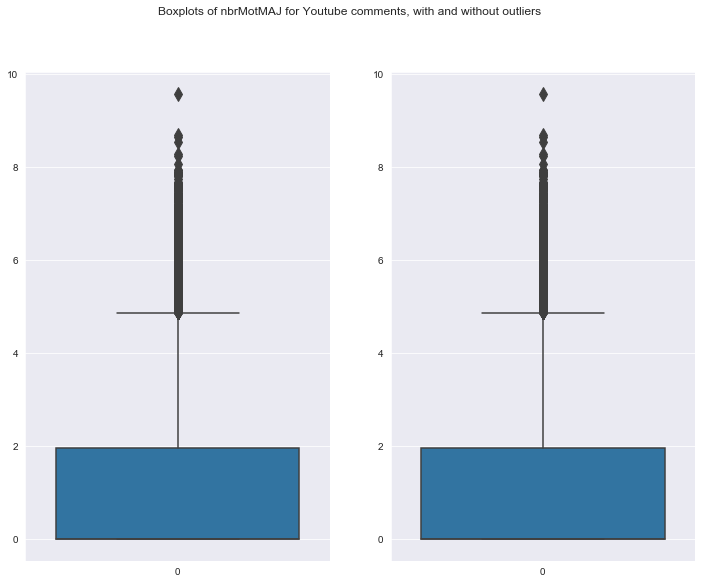

<Figure size 864x648 with 0 Axes>

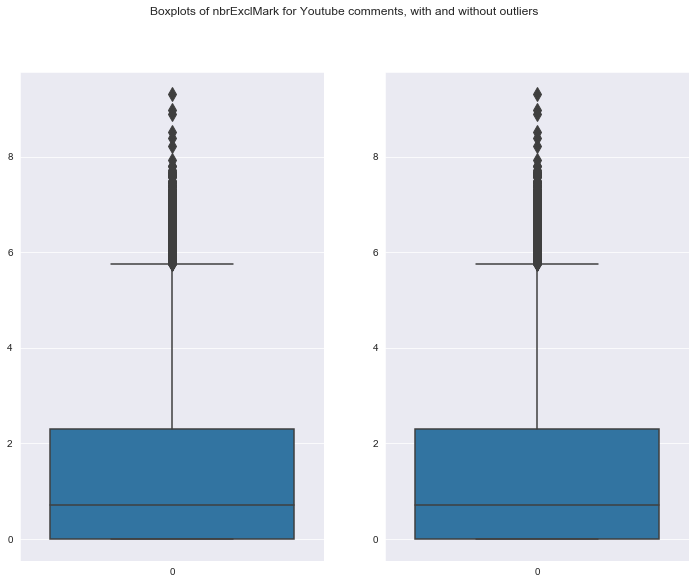

<Figure size 864x648 with 0 Axes>

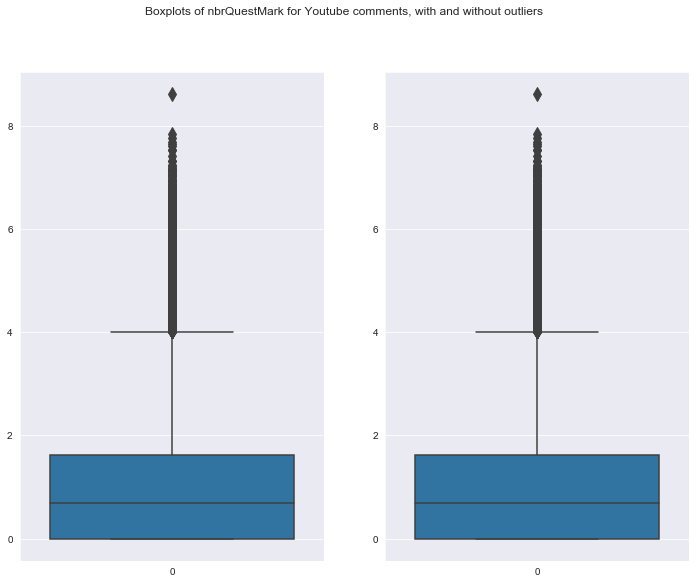

<Figure size 864x648 with 0 Axes>

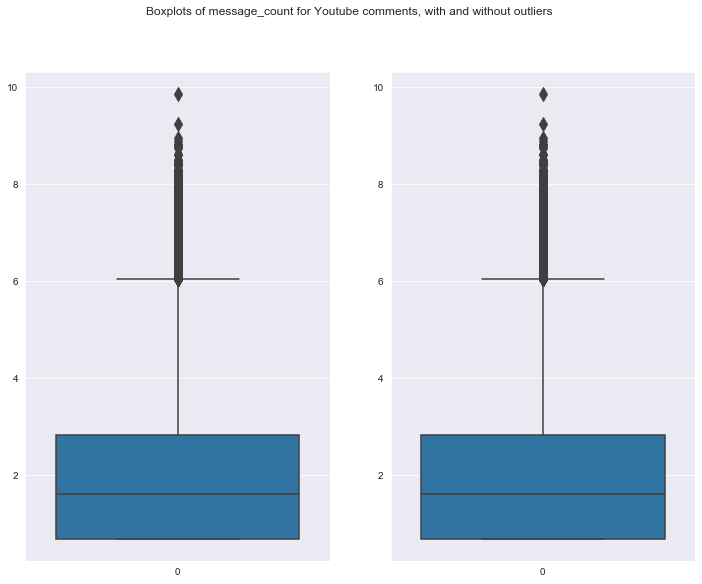

<Figure size 864x648 with 0 Axes>

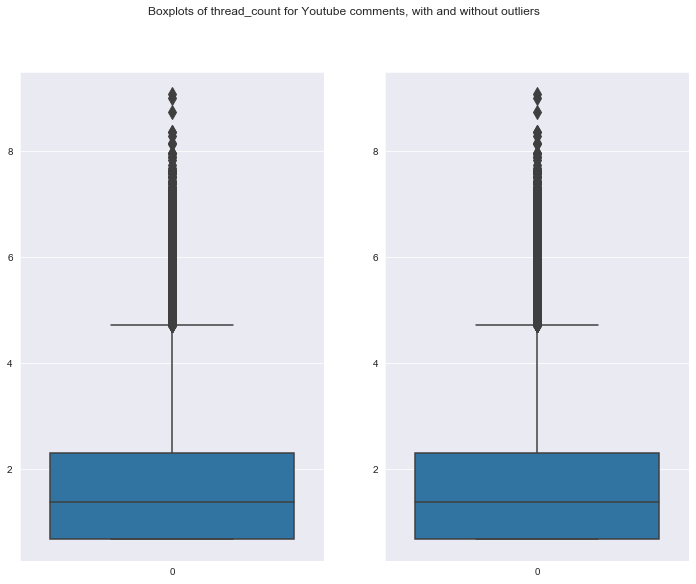

<Figure size 864x648 with 0 Axes>

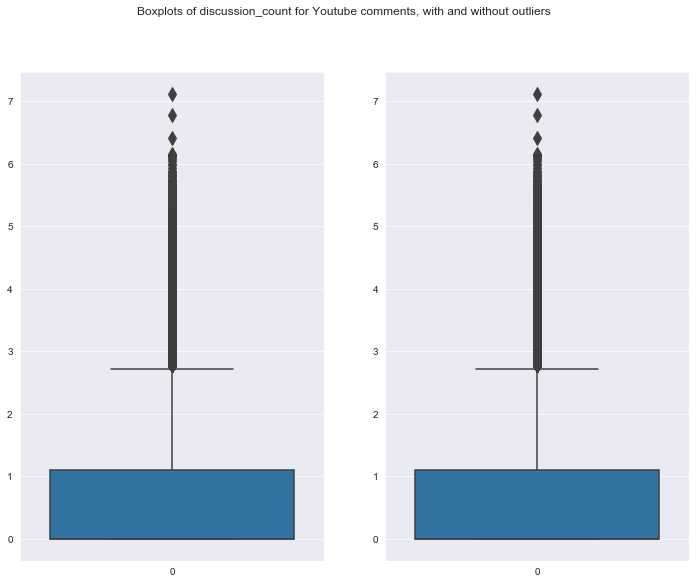

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

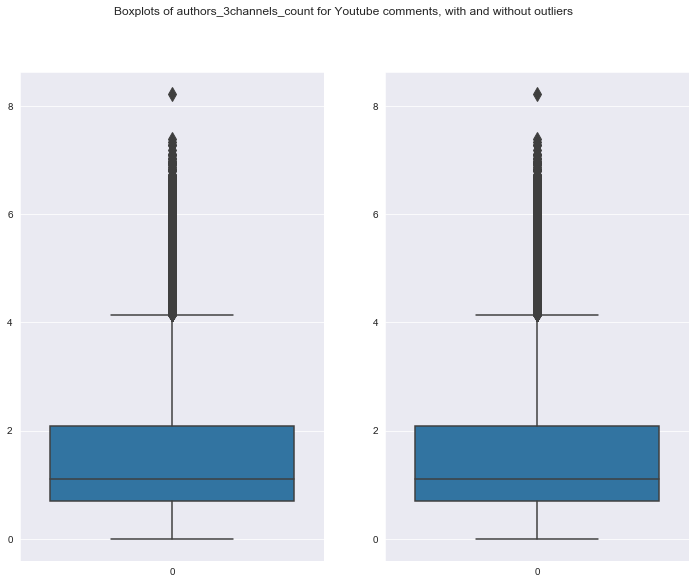

<Figure size 864x648 with 0 Axes>

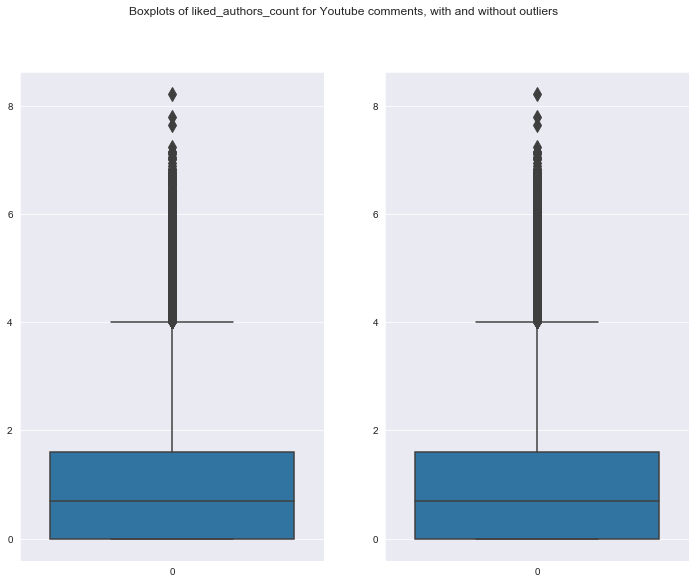

<Figure size 864x648 with 0 Axes>

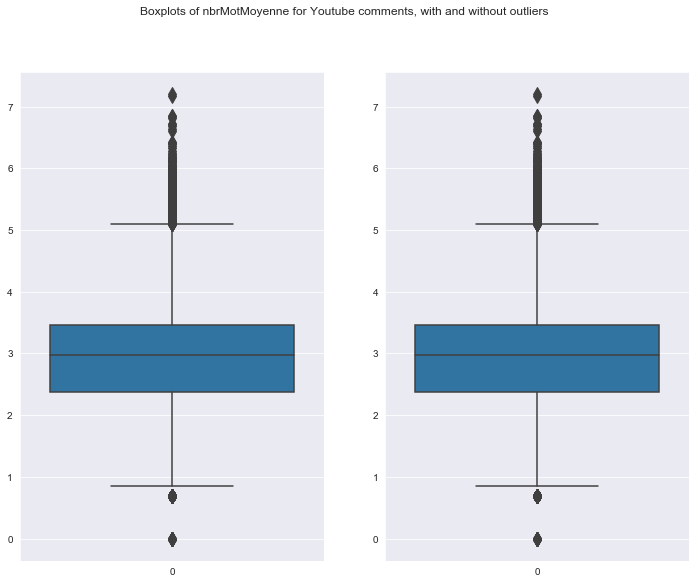

<Figure size 864x648 with 0 Axes>

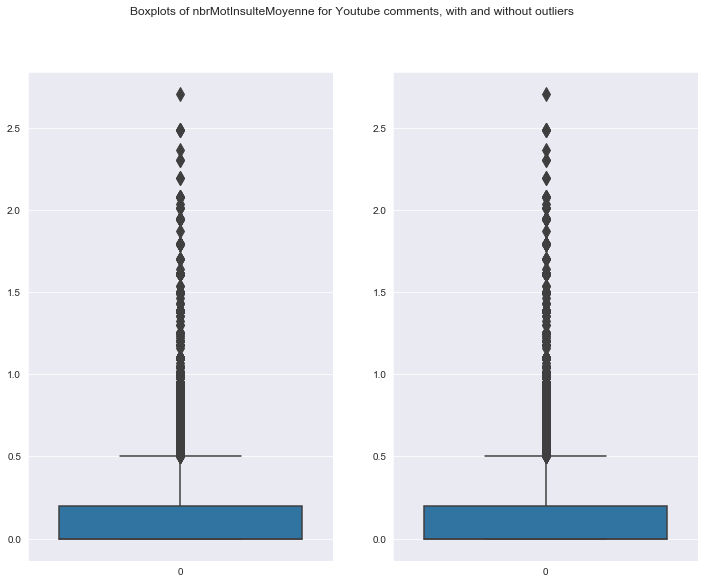

<Figure size 864x648 with 0 Axes>

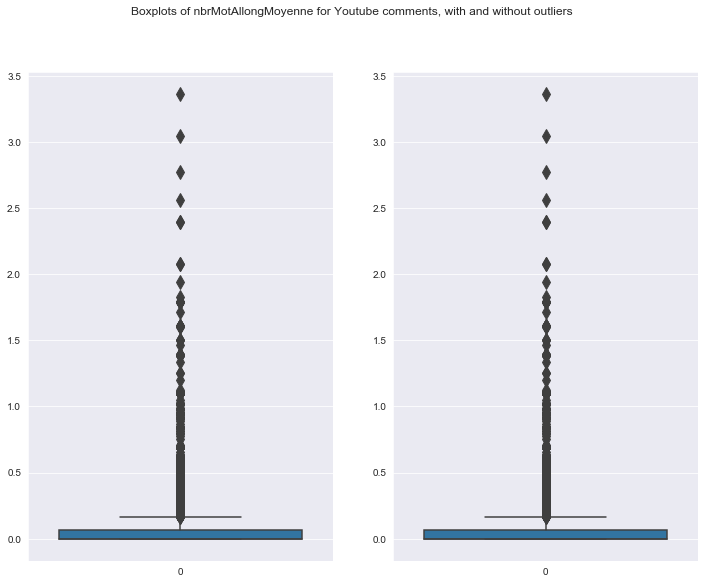

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

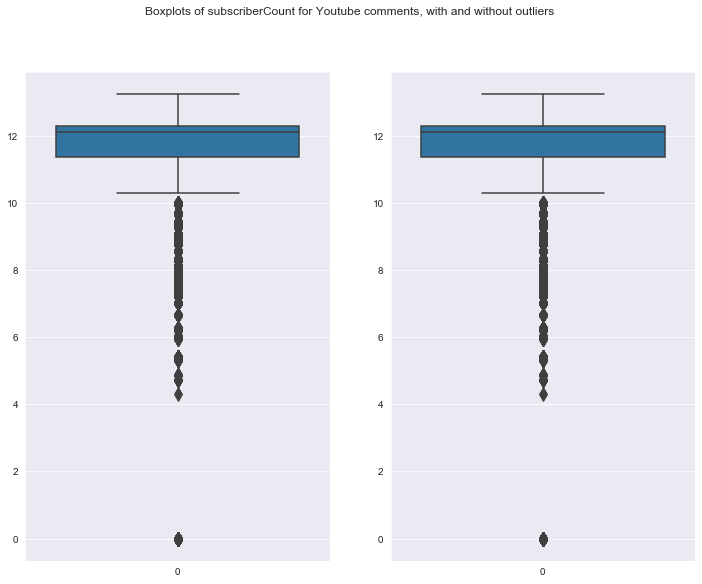

<Figure size 864x648 with 0 Axes>

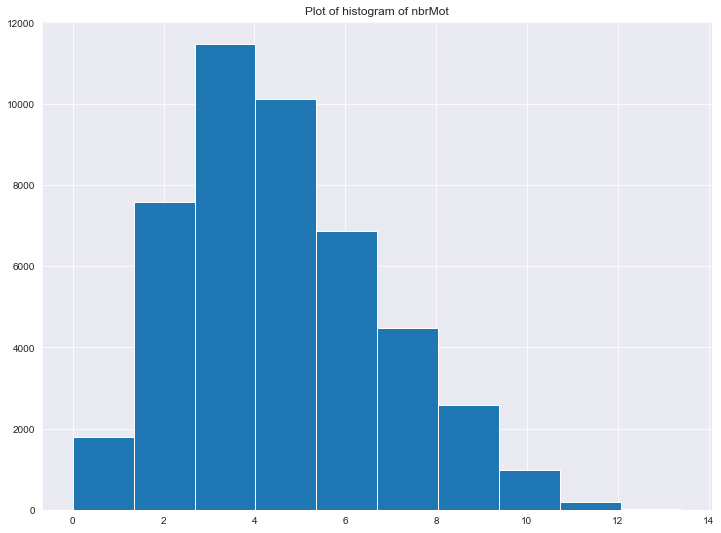

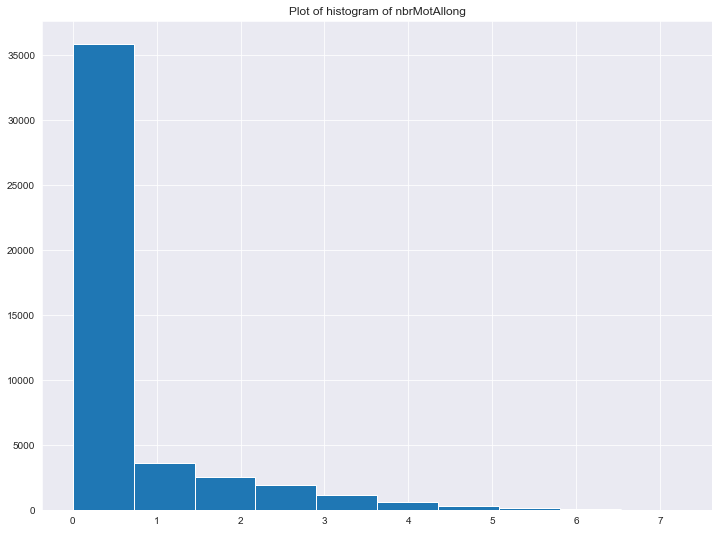

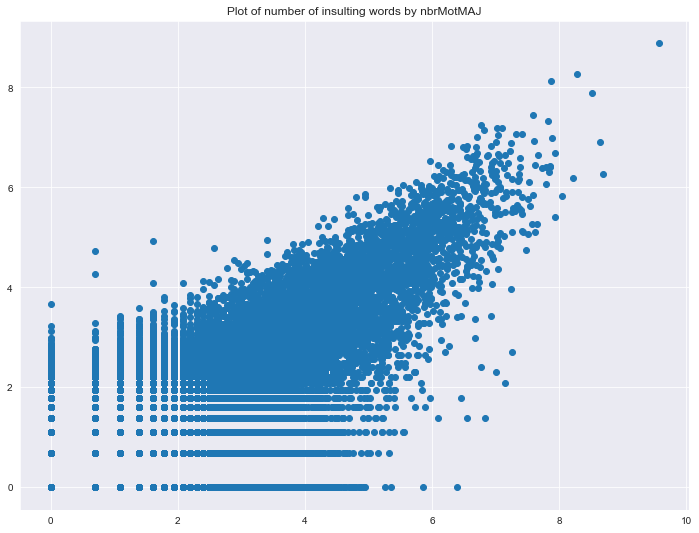

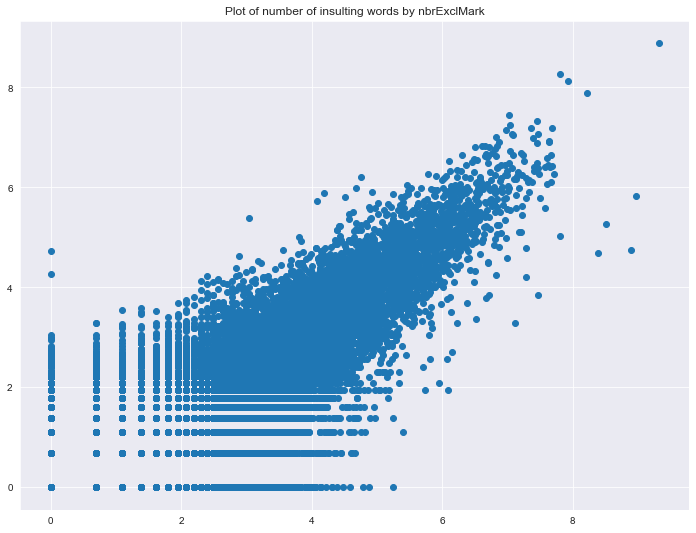

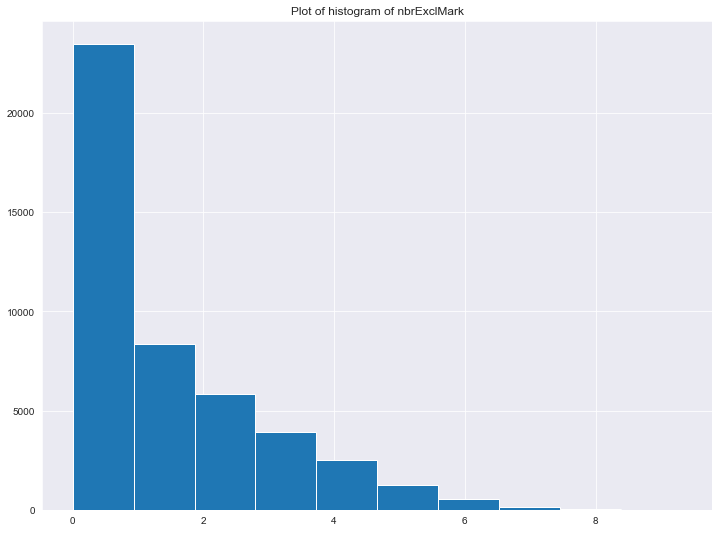

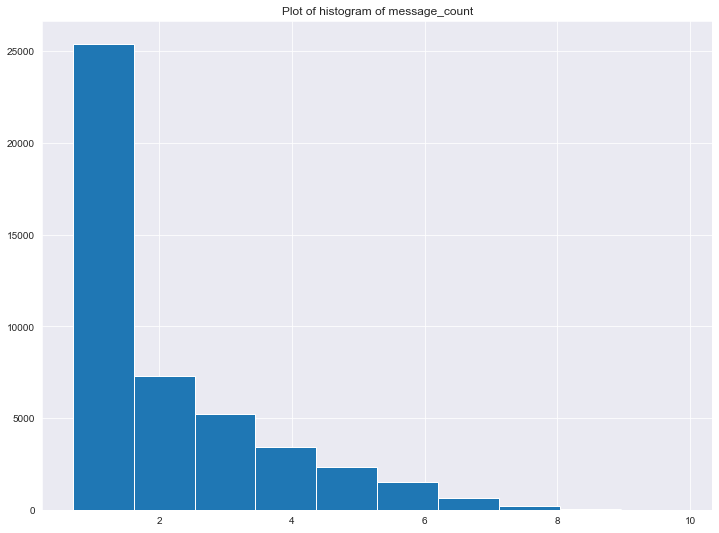

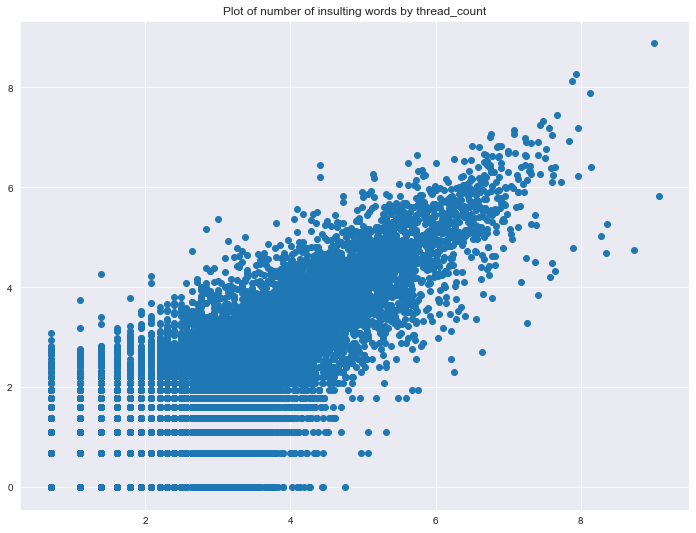

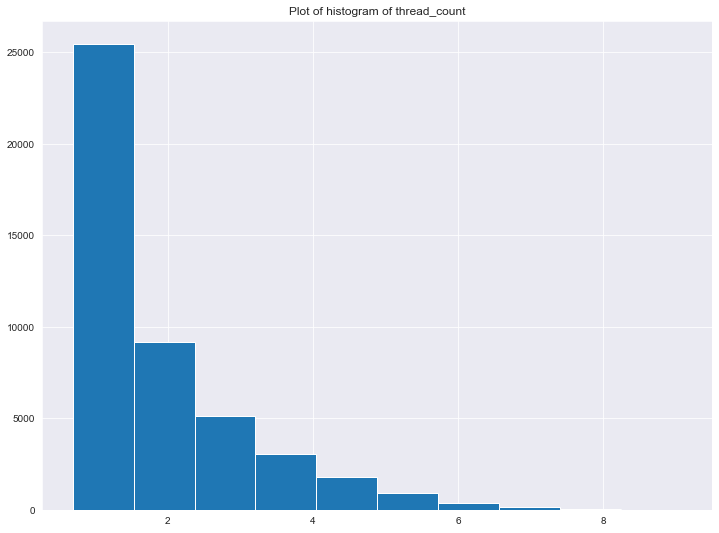

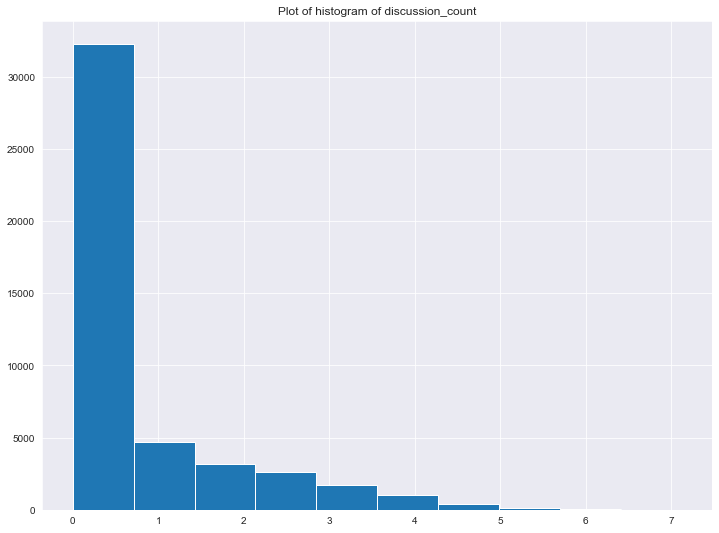

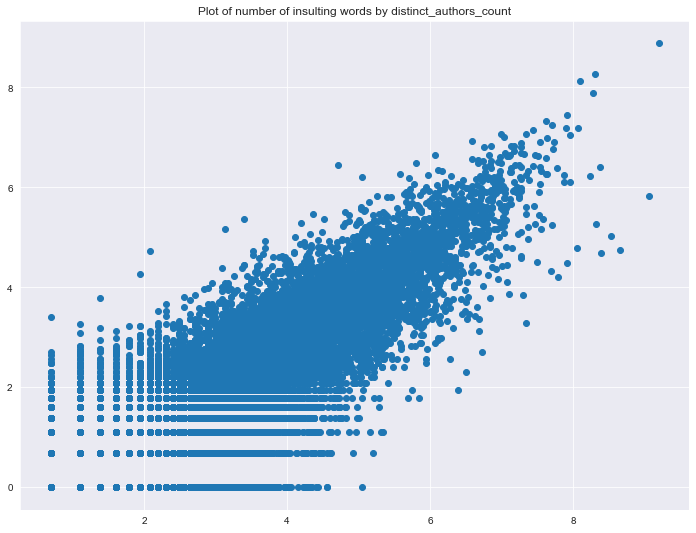

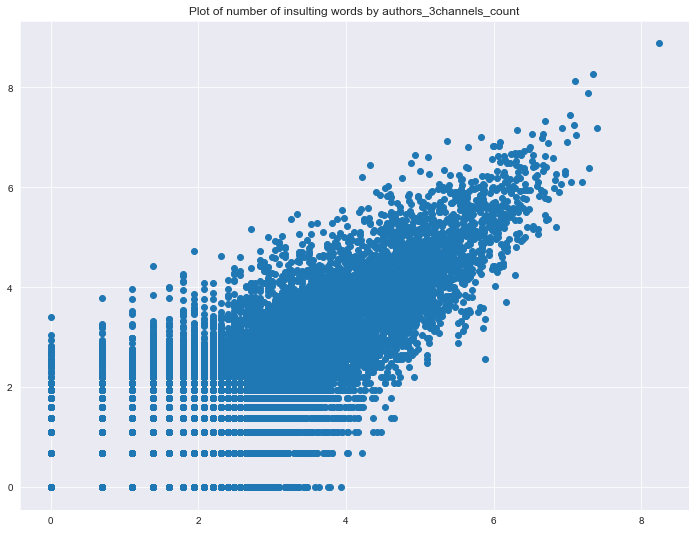

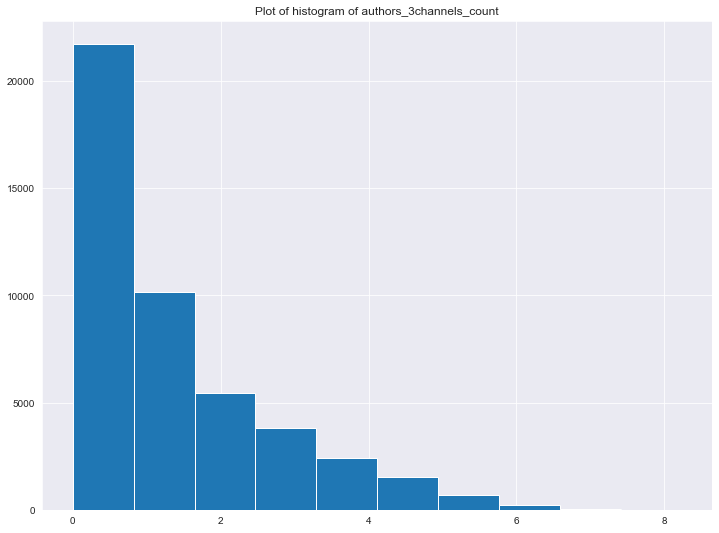

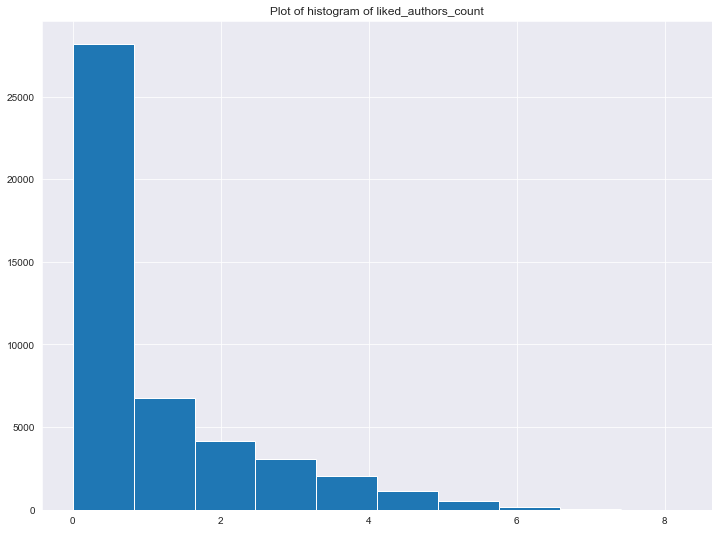

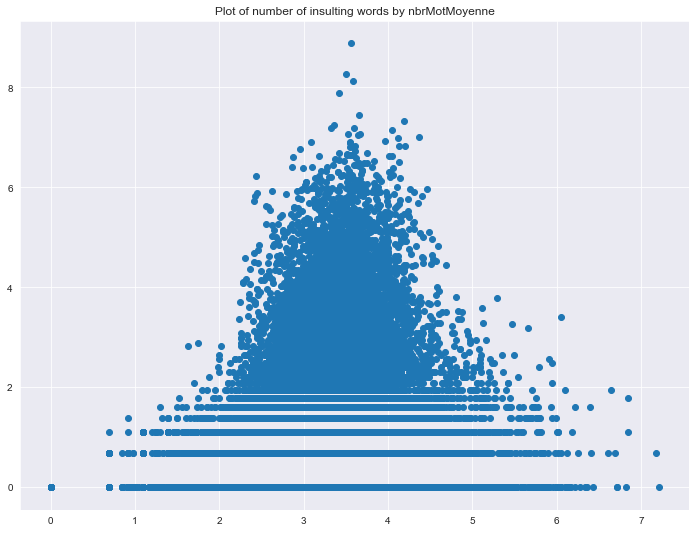

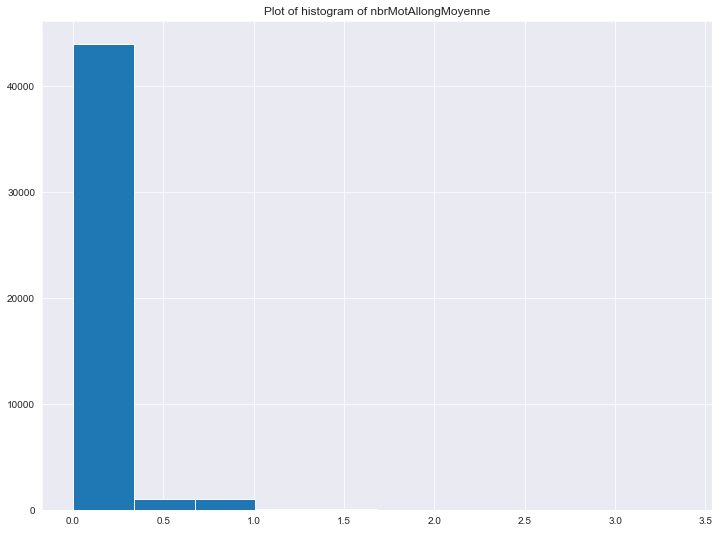

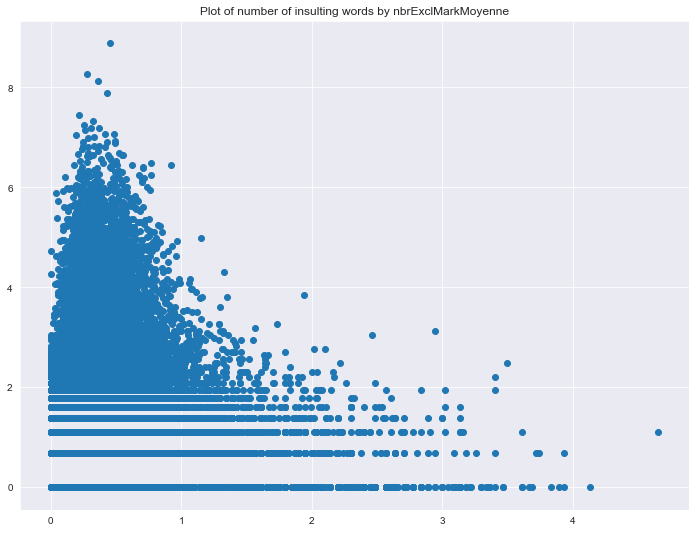

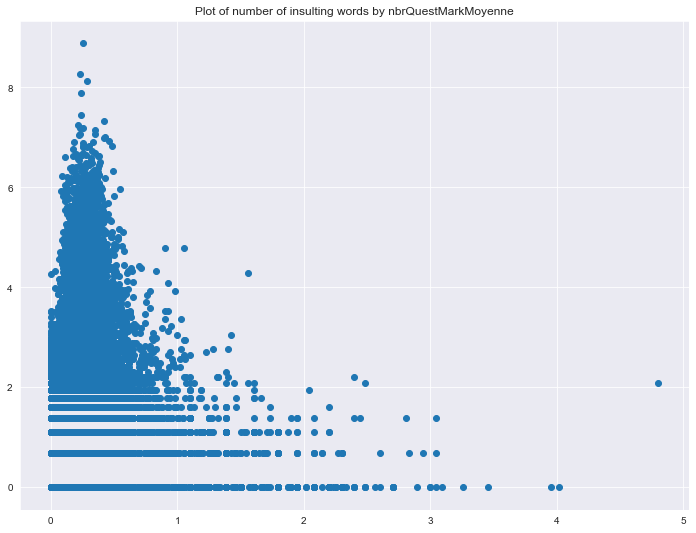

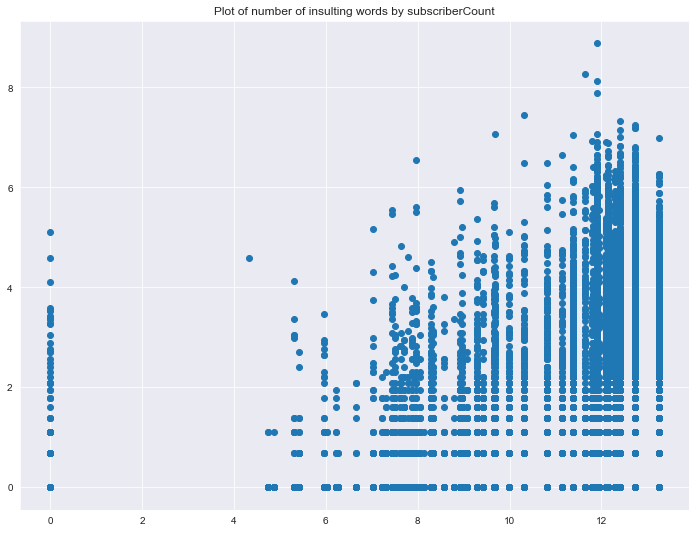

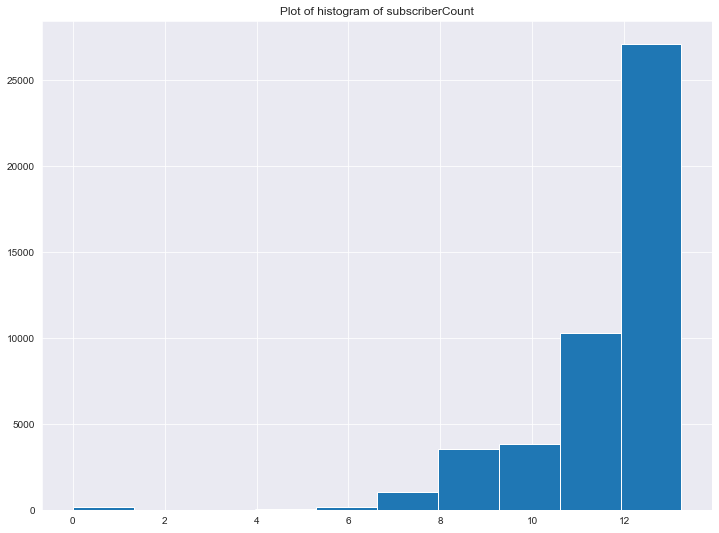

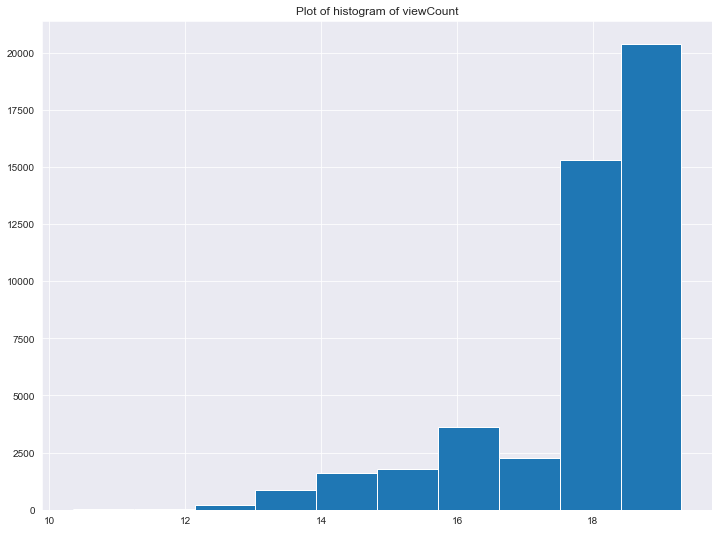

dataset created


In [21]:
X_train, Y_train, X_test, Y_test = create_dataset(plot=True, log=True)

La comparaison des deux matrices de corrélation nous montre que les corrélations sont relativement les mêmes mais ici plus extrêmes, cela nous conforte dans notre idée de prendre le log.

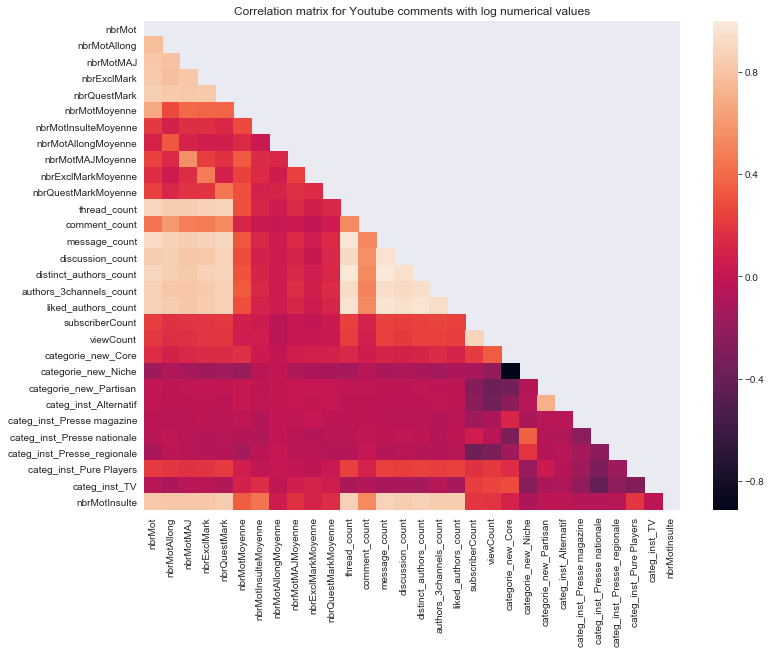

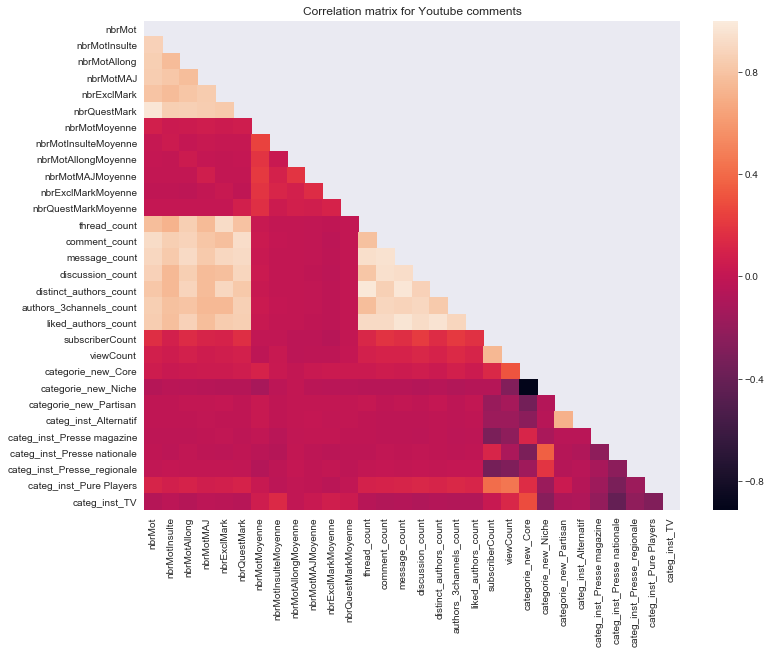

In [22]:
df_corr_log = pd.concat([X_train, X_test])
y1 = pd.DataFrame(Y_train, columns=['nbrMotInsulte'])
y2 = pd.DataFrame(Y_test, columns=['nbrMotInsulte'])
y_corr = pd.concat([y1, y2])
df_corr_log = pd.concat([df_corr_log, y_corr], axis=1)
correlation_matrix(df_corr_log, log=True)
correlation_matrix(df_corr)

In [23]:
scores_on_train = {}
mse_on_test = {}
r2_on_test = {}
ratio_on_test = {}

### KNN

On applique la même procédure sur ce dataset pour le KNN, avec des résultats bien plus concluants. 

In [24]:
algo = neighbors.KNeighborsRegressor
reg = algo()
reg = parameter_tuning(reg, {'n_neighbors': [2, 3, 4, 5]}, cv=3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  1.6min finished


cross validation score of KNeighborsRegressor(): -0.07859451588683015


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished


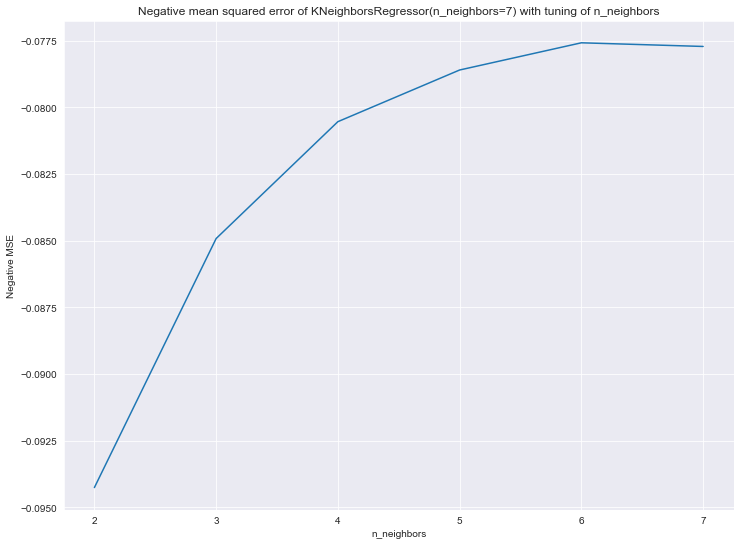

In [25]:
show_one_parameter(algo, 'n_neighbors', list(range(2, 8)), cv=3)

Les résultats ici sont bien meilleurs, avec quand même une forme de la répartition de la prédiction toujours en log. Nous voyons ici mieux la différence entre la prédiction et la valeur à prédire, nous avons globalement des valeurs assez proches.

In [26]:
plot_results(reg, True)

scores on test set
MSE:  0.04658152910637237
r2:  0.9694484928623067
Ratio of right predictions:  0.7113882863340564



### Decision tree

Même procédure pour l'arbre de décision. 

In [27]:
algo = tree.DecisionTreeRegressor
reg = algo()
reg = parameter_tuning(reg, {'max_depth': [10, 15, 20, 25, 30]}, cv=3)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    3.0s finished


cross validation score of DecisionTreeRegressor(max_depth=20): -0.006854342994482281


On voit ici qu'un max_depth à 10 décroit la performance significativement, il faut donc éviter un trop grand pruning.

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   

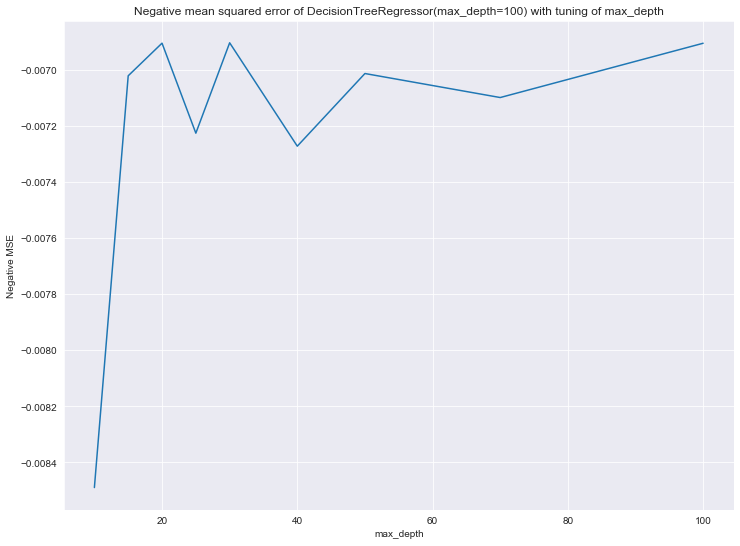

In [28]:
show_one_parameter(algo, 'max_depth', [10, 15, 20, 25, 30, 40, 50, 70, 100], cv=3)

C'est pire pour ccp_alpha, on garde la valeur par défaut.

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   

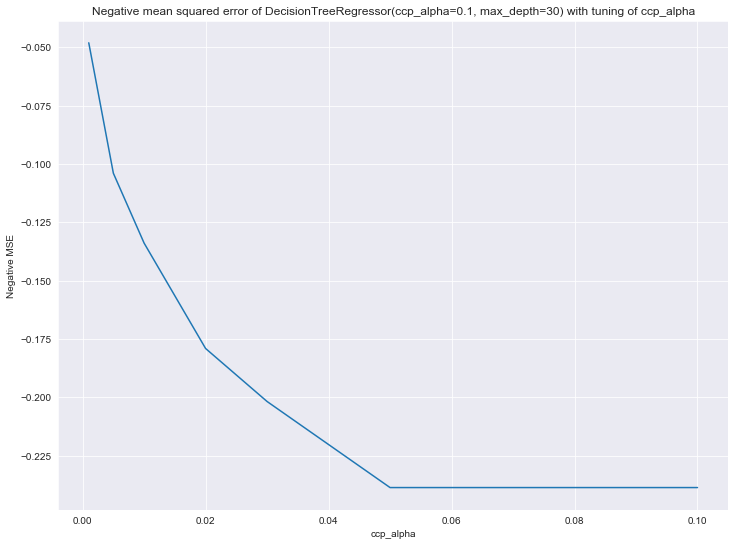

In [29]:
# ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning
show_one_parameter(algo, 'ccp_alpha', [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1], cv=3, kwargs={'max_depth': 30})

Nos résultats sont ici trop parfaits. Nous avons tenté de mélanger les données d'entrées mais cela ne change rien. Nous soupçonnons une erreur de code.

scores on test set
MSE:  3.127550592440501e-08
r2:  0.9999999807032576
Ratio of right predictions:  1.0



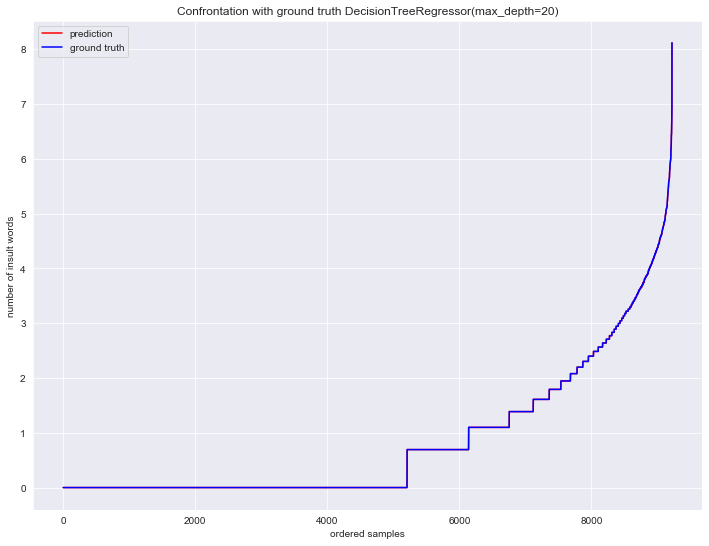

In [30]:
plot_results(reg, True)

### Random forest

Nous optimisons les random forests par rapport au nombre d'estimateurs et la profondeur maximale des arbres. Un grand nombre d'estimateurs est préférable mais nous le limitons pour des raisons de temps d'exécution. La profondeur maximale impacte peu les résultats, on peut donc la prendre basse.

In [31]:
algo = RandomForestRegressor
reg = algo()
reg = parameter_tuning(reg, {'n_estimators': [20, 30], 'max_depth': [30, 50], 'n_jobs': [3]}, cv=3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   16.6s finished


cross validation score of RandomForestRegressor(max_depth=30, n_estimators=30, n_jobs=3): -0.003198629770787446


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


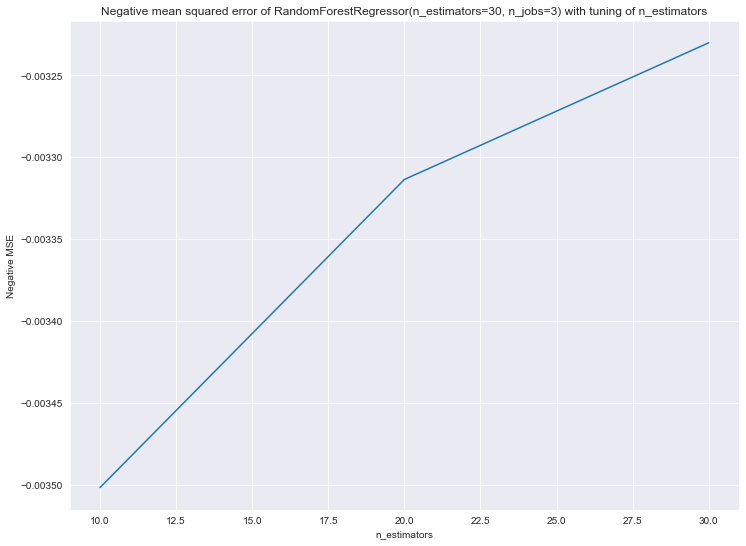

In [32]:
show_one_parameter(algo, 'n_estimators', [10, 20, 30], cv=3, kwargs={'n_jobs': 3})

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.3s finished


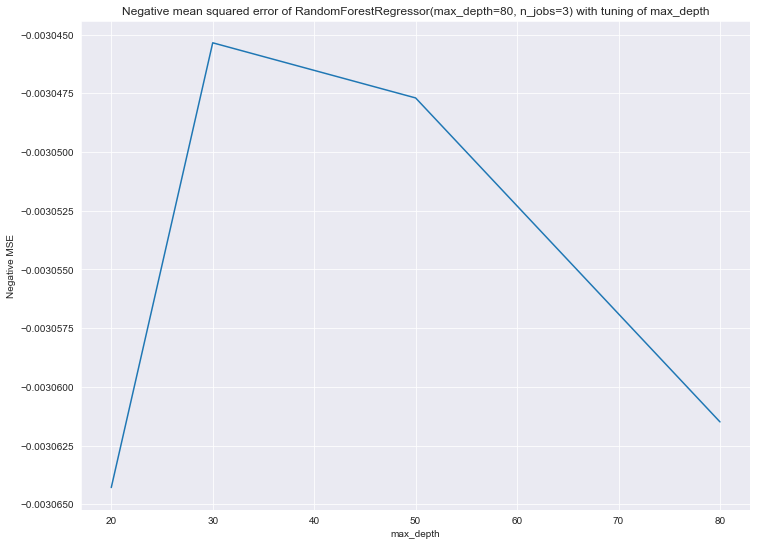

In [33]:
show_one_parameter(algo, 'max_depth', [20, 30, 50, 80], cv=3, kwargs={'n_jobs': 3, 'n_estimators': 100})

On a obtenu un estimateur avec un meilleur r2 et MSE que le knn, mais moins bon l'estimateur parfait que nous avions avec l'arbre de décision. Le ratio de bonnes décisions sur le test set est à 95% et cela semble être notre meilleur algorithme avec le meilleur dataset.

scores on test set
MSE:  0.0004235671573669414
r2:  0.9997382832188995
Ratio of right predictions:  0.9441431670281996



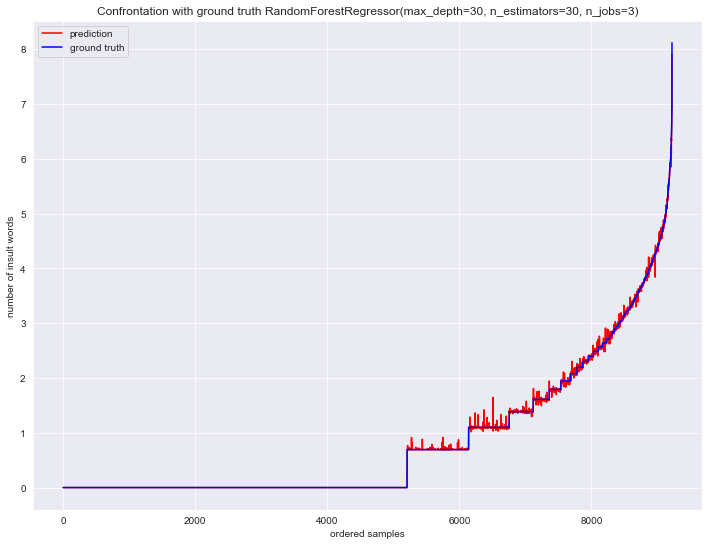

In [34]:
plot_results(reg, True)

### Support Vector Regression

SVR possède différents hyperparamètres :
    - epsilon, qui influe sur la fonction de perte.
    - C, le paramètre de régularisation.
    - tol, la tolérance d'arrêt.
    - max_iter, le nombre d'itérations maximal.

In [45]:
algo = LinearSVR
reg = algo()
param = {}
reg = parameter_tuning(reg, param, cv=3)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.8s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


cross validation score of LinearSVR(): -0.1299958281698157


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   17.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.9s finished


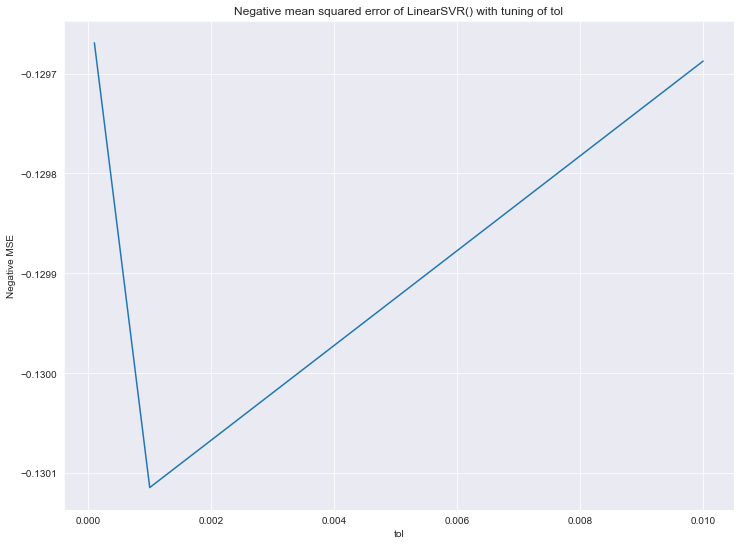

In [36]:
show_one_parameter(algo, 'tol', [0.01, 0.001, 0.0001], cv=3)

scores on test set
MSE:  0.12836542780246296
r2:  0.9179911904397642
Ratio of right predictions:  0.6365509761388286



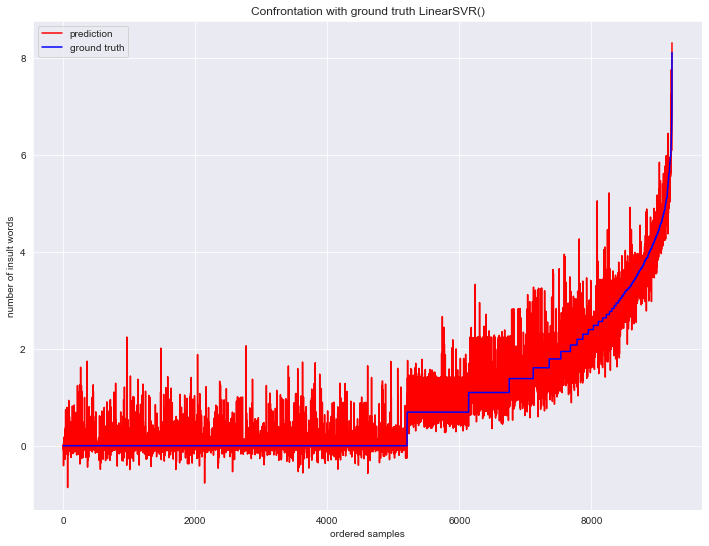

In [48]:
plot_results(reg, True)

Nous avons ici de moins bons résultats concernant la prédiction.

### Deep learning

In [38]:
#Convert numpy array into dataframe
Y_train_deep = pd.DataFrame(data=Y_train, columns=["nbrMotInsulte"])
Y_test_deep = pd.DataFrame(data=Y_test, columns=["nbrMotInsulte"])

In [39]:
#Create a custom Dataset for the data loaders
class CustomDataset(Dataset):

    def __init__(self, df_x, df_y):
        """
        :param df_x: pandas.DataFrame that contains our input data
        :param df_y: pandas.DataFrame that contains our target data
        """
        self.df_x = df_x
        self.df_y = df_y

    def __len__(self):
        return len(self.df_x)

    def __getitem__(self, item):
        x_sample = self.df_x.iloc[item, :]
        nbMots = self.df_y.iloc[item, :]
        x_sample = torch.tensor(x_sample).float()
        nbMots = torch.tensor(nbMots).float()
        return x_sample, nbMots

class Net(nn.Module):

    # class initialization
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        # fully connected layer with linear activation
        self.fc0 = nn.Linear(input_size, hidden_size)
        # ReLu activation
        self.relu = nn.ReLU()
        # fully connected layer with linear activation
        self.fc1 = nn.Linear(hidden_size, output_size)

    # function to apply the neural network
    def forward(self, x):
        out = self.fc0(x)
        out = self.relu(out)
        y_pred = self.fc1(out)
        return y_pred

train_dataset = CustomDataset(X_train, Y_train_deep)
test_dataset = CustomDataset(X_test, Y_test_deep)
train_loader = DataLoader(train_dataset, batch_size=20)
test_loader = DataLoader(test_dataset, batch_size=20)

# Create the neural network
# 10 neurons in the hidden layer, and 1 output size for y
net = Net(len(X_train.columns), 10, 1)
net = net.float()
# Loss function: MSE = sum [(y - y_pred)^2]
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.001)

Le nombre d'itérations est fixé à 3 pour des raisons de temps d'exécution puisque nous l'avons fait tourner avec 10 itérations et les résultats étaient similaires.

In [40]:
def training():
    #train the model
    epochs = 3 # number of epochs
    # Loop on epochs
    for i in range(epochs):
        print(i/epochs)
        for i, data in enumerate(train_loader, 0):
            inputs, nbMots = data
            optimizer.zero_grad()
            output = net(inputs)
            loss = criterion(output, nbMots)
            loss.backward()
            optimizer.step()
    print('Finished training')
    
training()

0.0
0.3333333333333333
0.6666666666666666
Finished training


In [41]:
def testing():
    correct = 0
    total = 0
    losses = []
    residus = []
    with torch.no_grad():
        loss = 0
        for inputs, nbMots in test_loader:
            output = net(inputs)
            for i in range(len(nbMots)):
                total += 1
                residus.append(abs(output[i][0] - nbMots[i][0]).detach().numpy().tolist())
                if abs(output[i][0] - nbMots[i][0]) <= 0.5:
                    correct += 1
            losses.append(criterion(output, nbMots))
    mse_loss = sum(losses)/len(losses)
    ratio = correct / total
    print("Finished testing")
    return(ratio, residus, mse_loss)

ratio, residus, mse_loss = testing()

Finished testing


On observe que les résidus (différence entre la prédiction et la vérité) sont effectivement concentrés autour de 0.

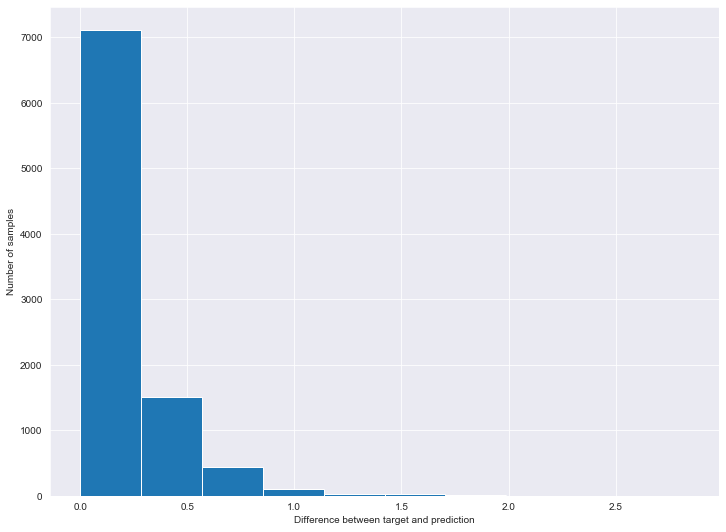

In [42]:
plt.xlabel('Difference between target and prediction')
plt.ylabel('Number of samples')
plt.hist(residus)
plt.show()

In [43]:
ratio_on_test['Deep Learning'] = ratio
mse_on_test['Deep Learning'] = mse_loss

Le réseau de neurones semble mieux prédire les résultats exacts (donc sûrement des valeurs basses) mais a un moins bon MSE que le knn. Nous n'avons pas la comparaison pour le trainset et le r2 sur le testset.

### Conclusion for regression with outliers limit

La régression marche en effet bien mieux avec ces features transformées. Un travail supplémentaire aurait été de vérifier l'importance des features avec un PCA au préalable pour potentiellement supprimer les features inutiles (notre intuition étant d'enlever les features avec les nombres de mots ou de marqueurs), et de faire des ratio pour le nombre d'auteurs (en divisant par exemple par le nombre de commentaires). Nous aurions alors pu garder la transformation log pour les features moyennes qui semble toujours pertinente. 

Notre meilleur algorithme sur le test set est le random forest si l'on excepte les résultats étranges de l'arbre de décision. On retrouve globalement la même hiérarchie sur le test set que sur le train set.

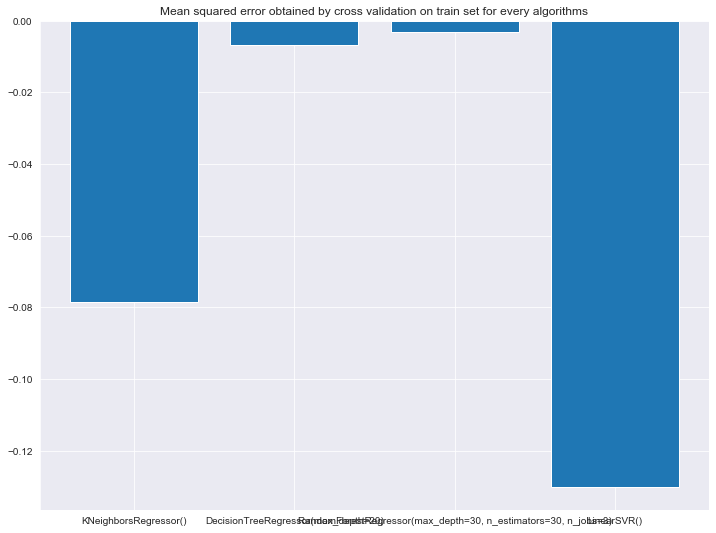

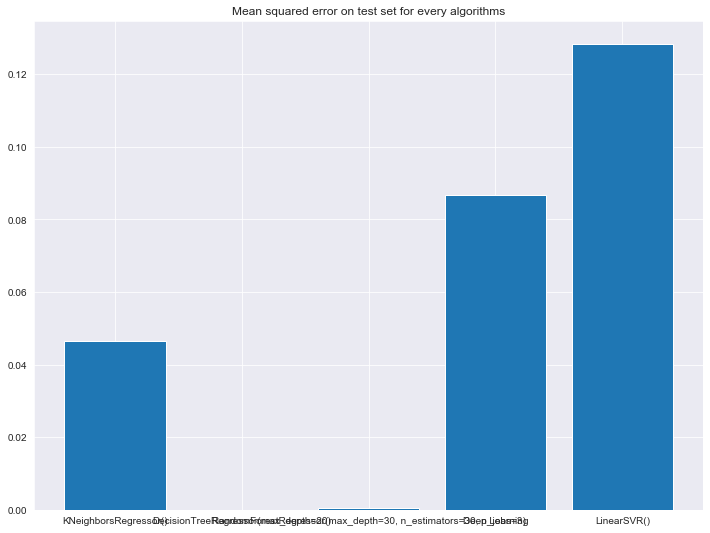

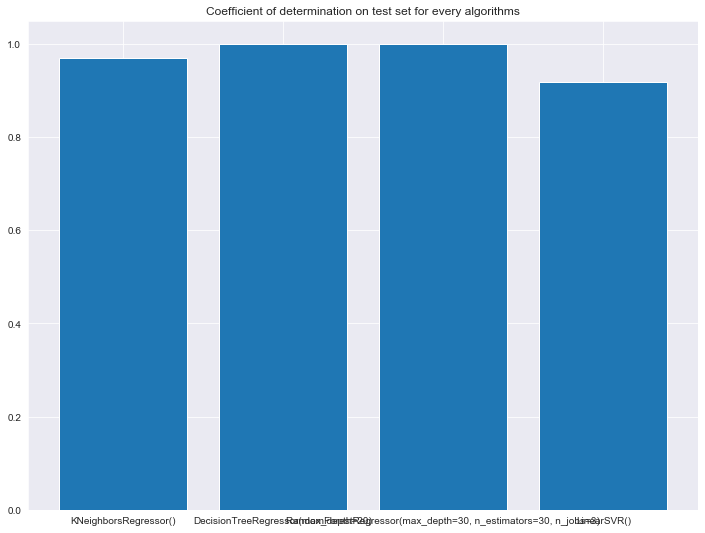

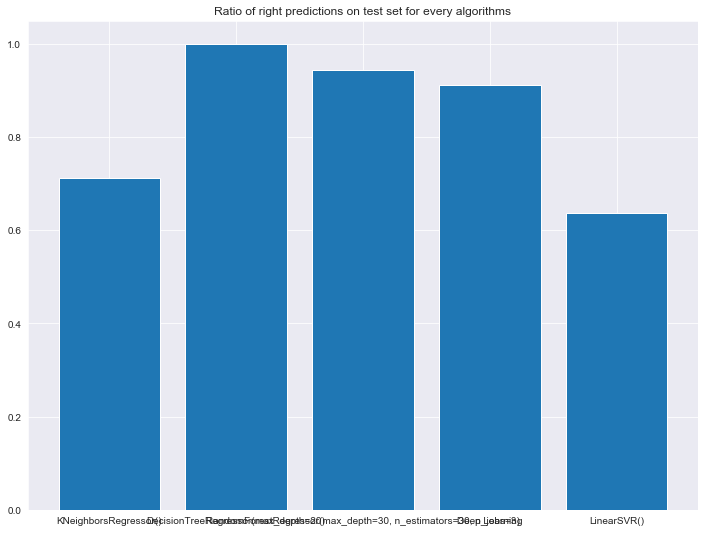

In [52]:
compare_scores()